In [28]:
%load_ext autoreload 
import numpy as np
from tqdm import tqdm
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from copy import copy
from collections import defaultdict, Counter
from sklearn.metrics import adjusted_rand_score, silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering, DBSCAN
from sklearn_extra.cluster import KMedoids
from joblib import Parallel, delayed

from hdbscan import validity_index as DBCV
from hdbscan import HDBSCAN
from clustering_utils import clustering_by_methods,\
                             clustering,\
                             plot_clustering_scatter,\
                             davies_bouldin_score_precomputed,\
                             prediction_strength_CV_precomputed

from utils import coord_to_pix, entropy
from IPython.display import clear_output

import warnings
warnings.simplefilter("ignore")
%autoreload 2

# see paper for the thresholds explanation
DBIND_THRESHOLD = 0.6
DBIND_MAX = 3.
SILHOUETTE_THRESH = 0.5
PS_THRESHOLD = 0.8
DBCV_THRESHOLD = 0.0
DATA_PRESERVED_THRESHOLD = 0.9

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [2]:
CPT = 0.01 # minimal percentage of the data in single cluster
DATA_SPECIFICATION = ''

clustering_results_root = f'results/clustering_cpt-{CPT}' + '_small_datasets'

if not os.path.exists(clustering_results_root):
    os.makedirs(clustering_results_root)

In [30]:
datasets_names = ['Sanger', 'Illumina', 'Pyroseq']
tax_names = ['g']

data_orig = {}
for dataset_name in tqdm(datasets_names):
    for tax in tax_names: 
        dataframe = pd.read_csv(f'./data_processed{DATA_SPECIFICATION}/{dataset_name}_{tax}.csv', sep=',')
        label = f'{dataset_name}_{tax}'
        data_orig[label] = dataframe.drop('Unnamed: 0', axis=1).values
    
data_pca = {}
for dataset_name in tqdm(datasets_names):
    for tax in tax_names: 
        label = f'{dataset_name}_{tax}'
        data_pca[label] = np.genfromtxt(f'./results/pca{DATA_SPECIFICATION}/{label}', delimiter=';')

    
distance_root = f'distances_processed{DATA_SPECIFICATION}'
distances_names = ['L1', 'L2', 'JS', 'BC']

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 428.87it/s]


# Clustering: precomputed distances

In [31]:
distances_orig = defaultdict(dict)
for metric_name in distances_names:
    for label in data_orig.keys(): 
        distances_orig[metric_name][label] = np.load(os.path.join(distance_root,\
                                                                  f'orig_{metric_name}_{label}.npy'), 
                                                     allow_pickle=True)

In [32]:
class SpectralClustering_prec:
    def __init__(self, *args, **kwargs):
        self.method = SpectralClustering(*args, **kwargs, affinity='precomputed', random_state=42)
    def fit_predict(self, X):
        '''
        X - pairwise_distance matrix
        '''
        A = np.exp(-self.method.gamma * np.abs(X))
        return self.method.fit_predict(A)

# PAM on JS

In [33]:
results_JS_PAM = {}
pam_method_params = {'n_clusters':None,
                    'method':'pam',
                    'metric':'precomputed',
                    'init':'k-medoids++',
                    'random_state':42}

for (label,D) in distances_orig['JS'].items():
    
    results_per_k = {}
    
    k = 3

    pam_method_params_k = pam_method_params.copy()
    pam_method_params_k['n_clusters'] = k
    method = KMedoids(**pam_method_params_k)
    labels = method.fit_predict(D)
    X = data_pca[label]

    results_per_k['labels'] = labels
    results_per_k['dbind'] = davies_bouldin_score_precomputed(D, labels)
    results_per_k['silh'] = silhouette_score(D, labels, metric='precomputed')
    results_per_k['dbcv'] = DBCV(D, labels, metric='precomputed', d=data_orig[label].shape[1])
    results_per_k['ps'] = prediction_strength_CV_precomputed(D, method=None, y=labels)

    # data mass distribution
    n = len(np.unique(labels))
    cl_dist = np.ones(n)
    for i in range(n):
        cl_dist[i] = sum(labels == i)/len(labels)

    results_per_k['entropy'] = entropy(cl_dist)
    
    results_JS_PAM[label] = results_per_k

In [34]:
pd.DataFrame(results_JS_PAM).T[['dbind', 'silh', 'dbcv', 'ps', 'entropy']]

dbind      silh      dbcv        ps   entropy
Sanger_g     1.43274  0.140819 -0.085042  0.422222  0.994924
Illumina_g  1.779577  0.156235 -0.308437   0.59127  1.055102
Pyroseq_g   1.584352  0.213157 -0.272912  0.630441  0.898864

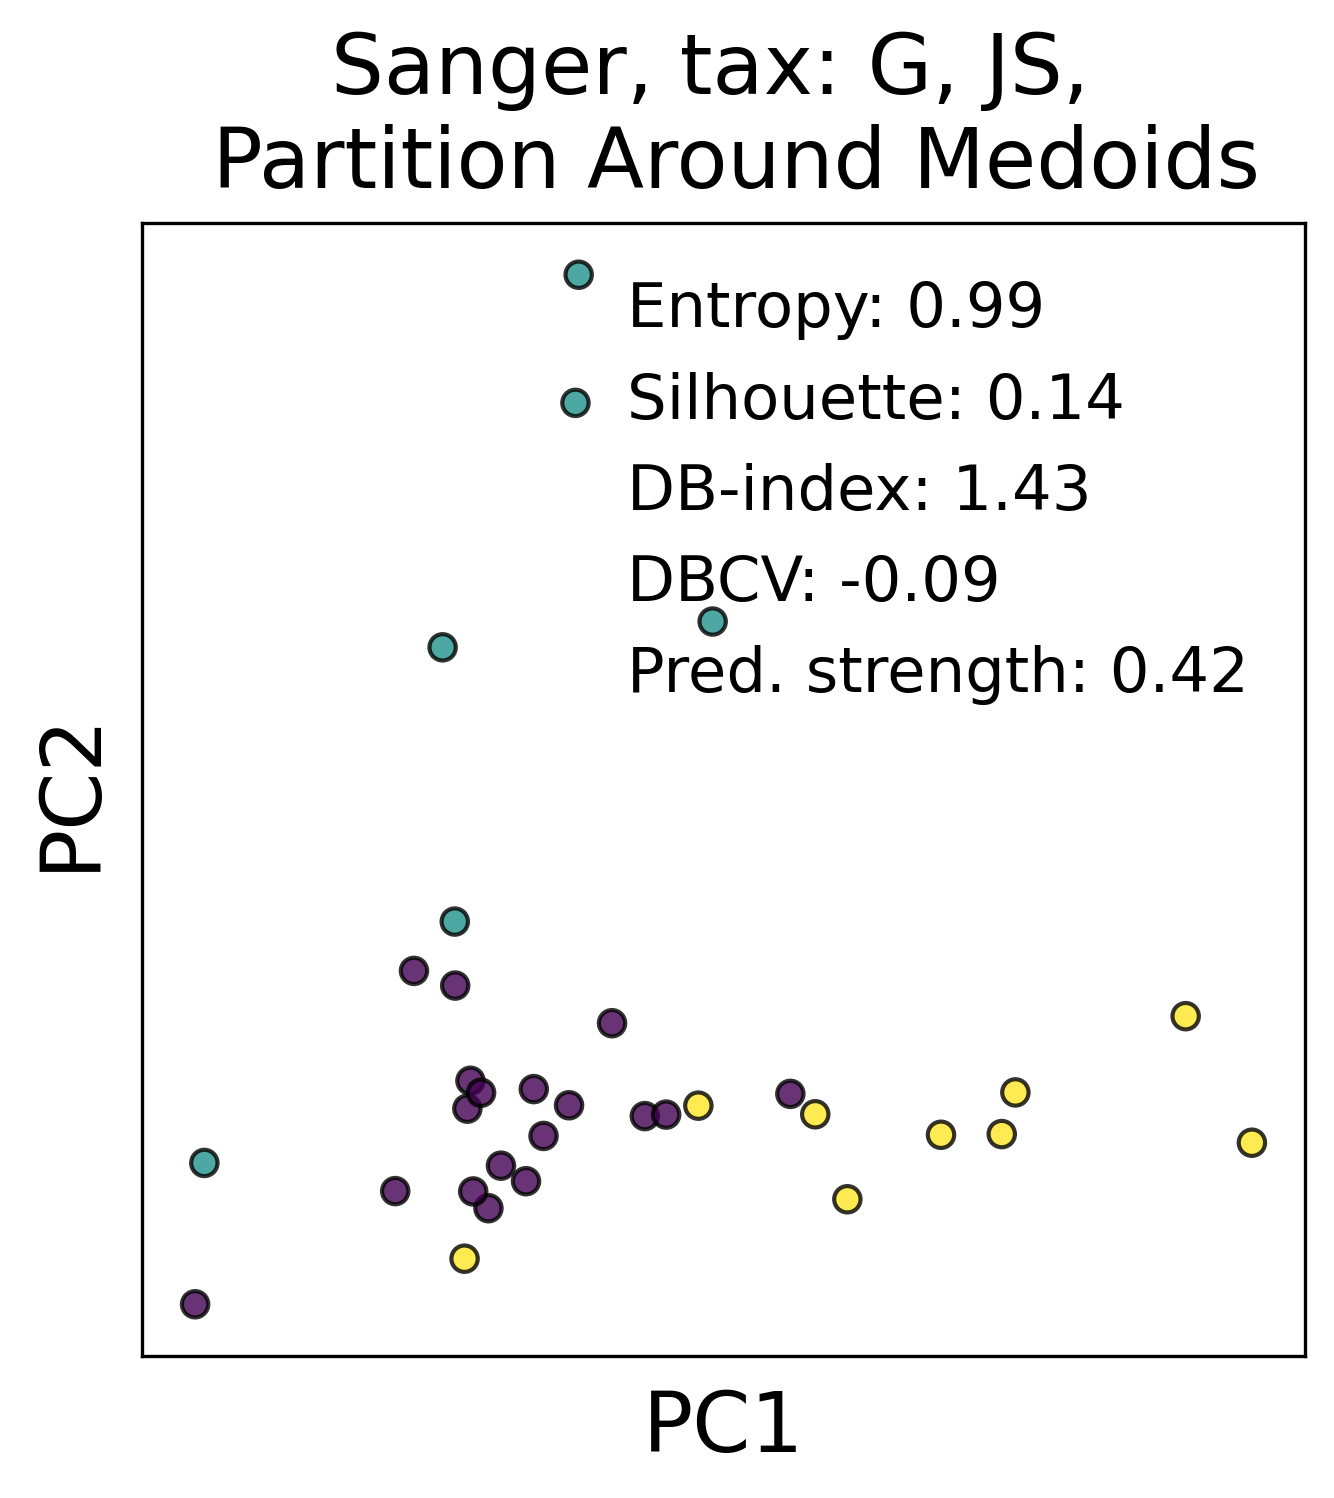

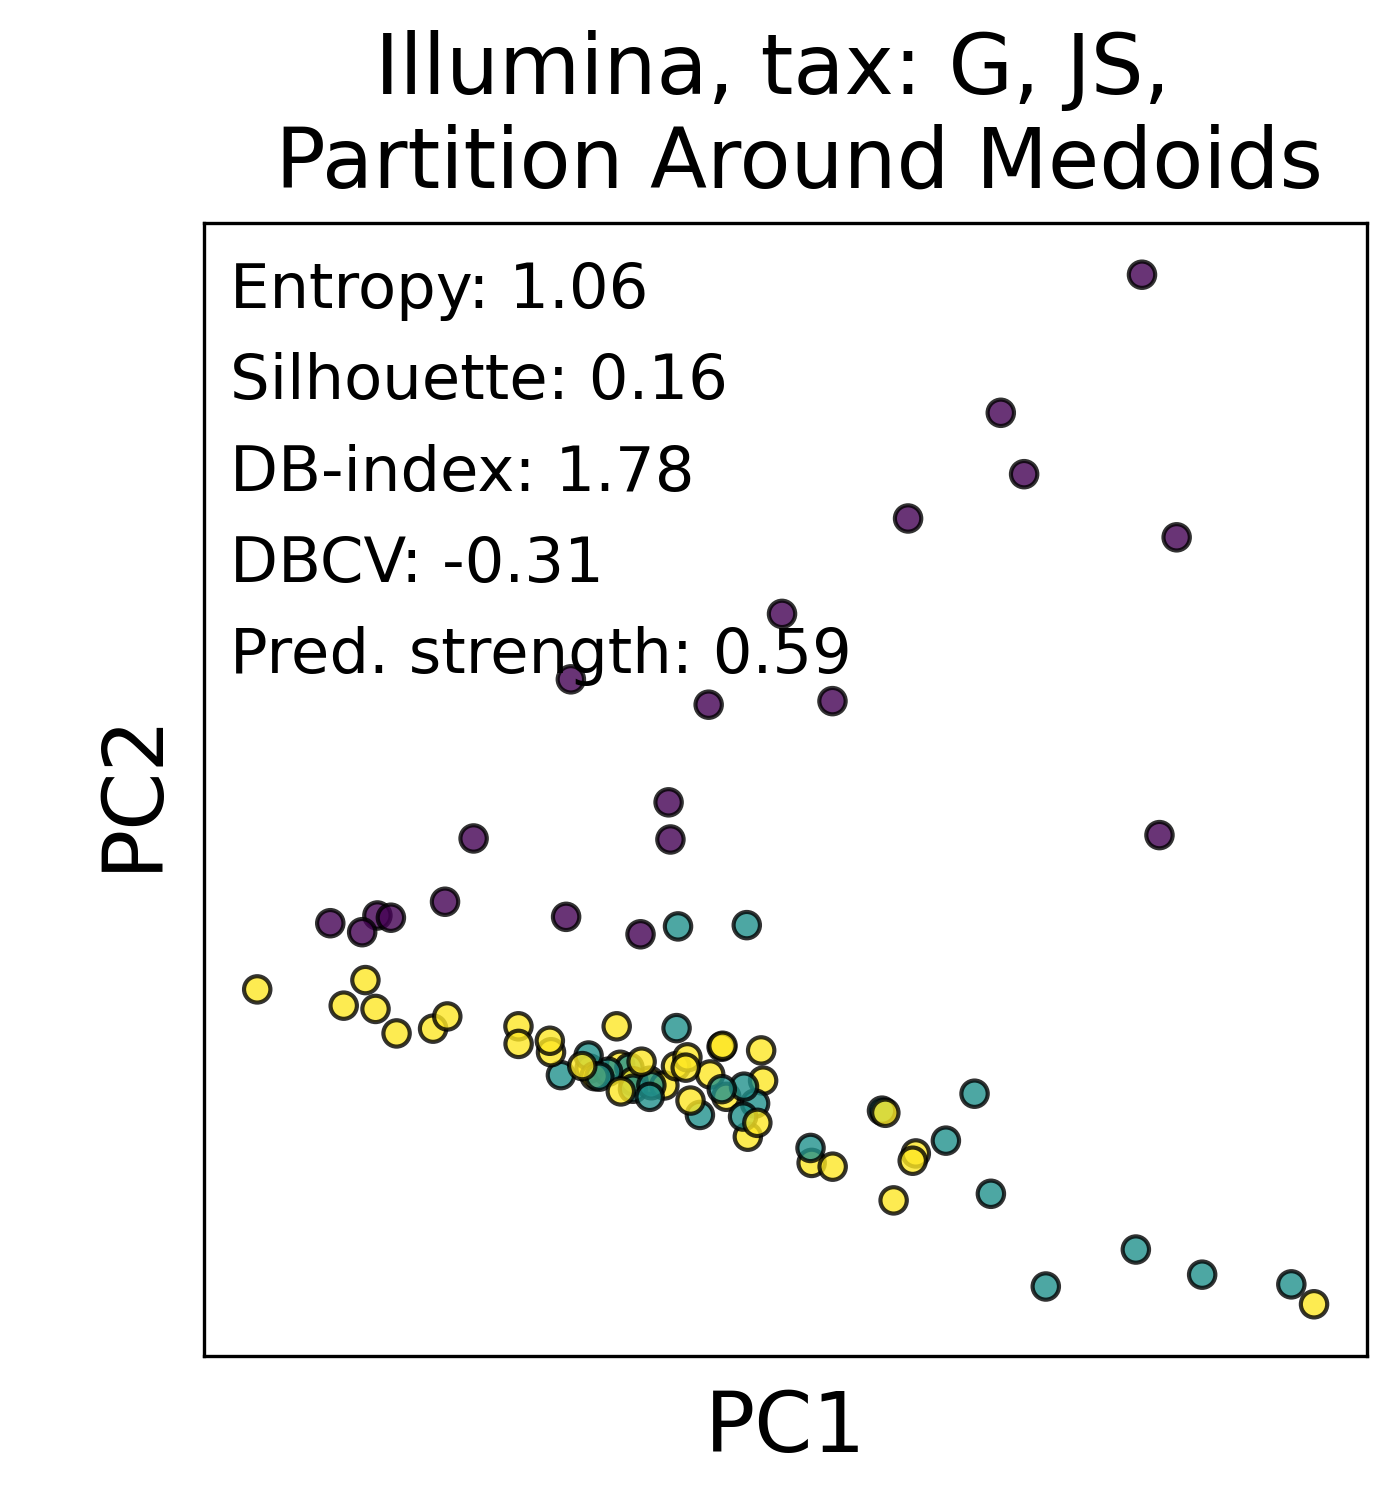

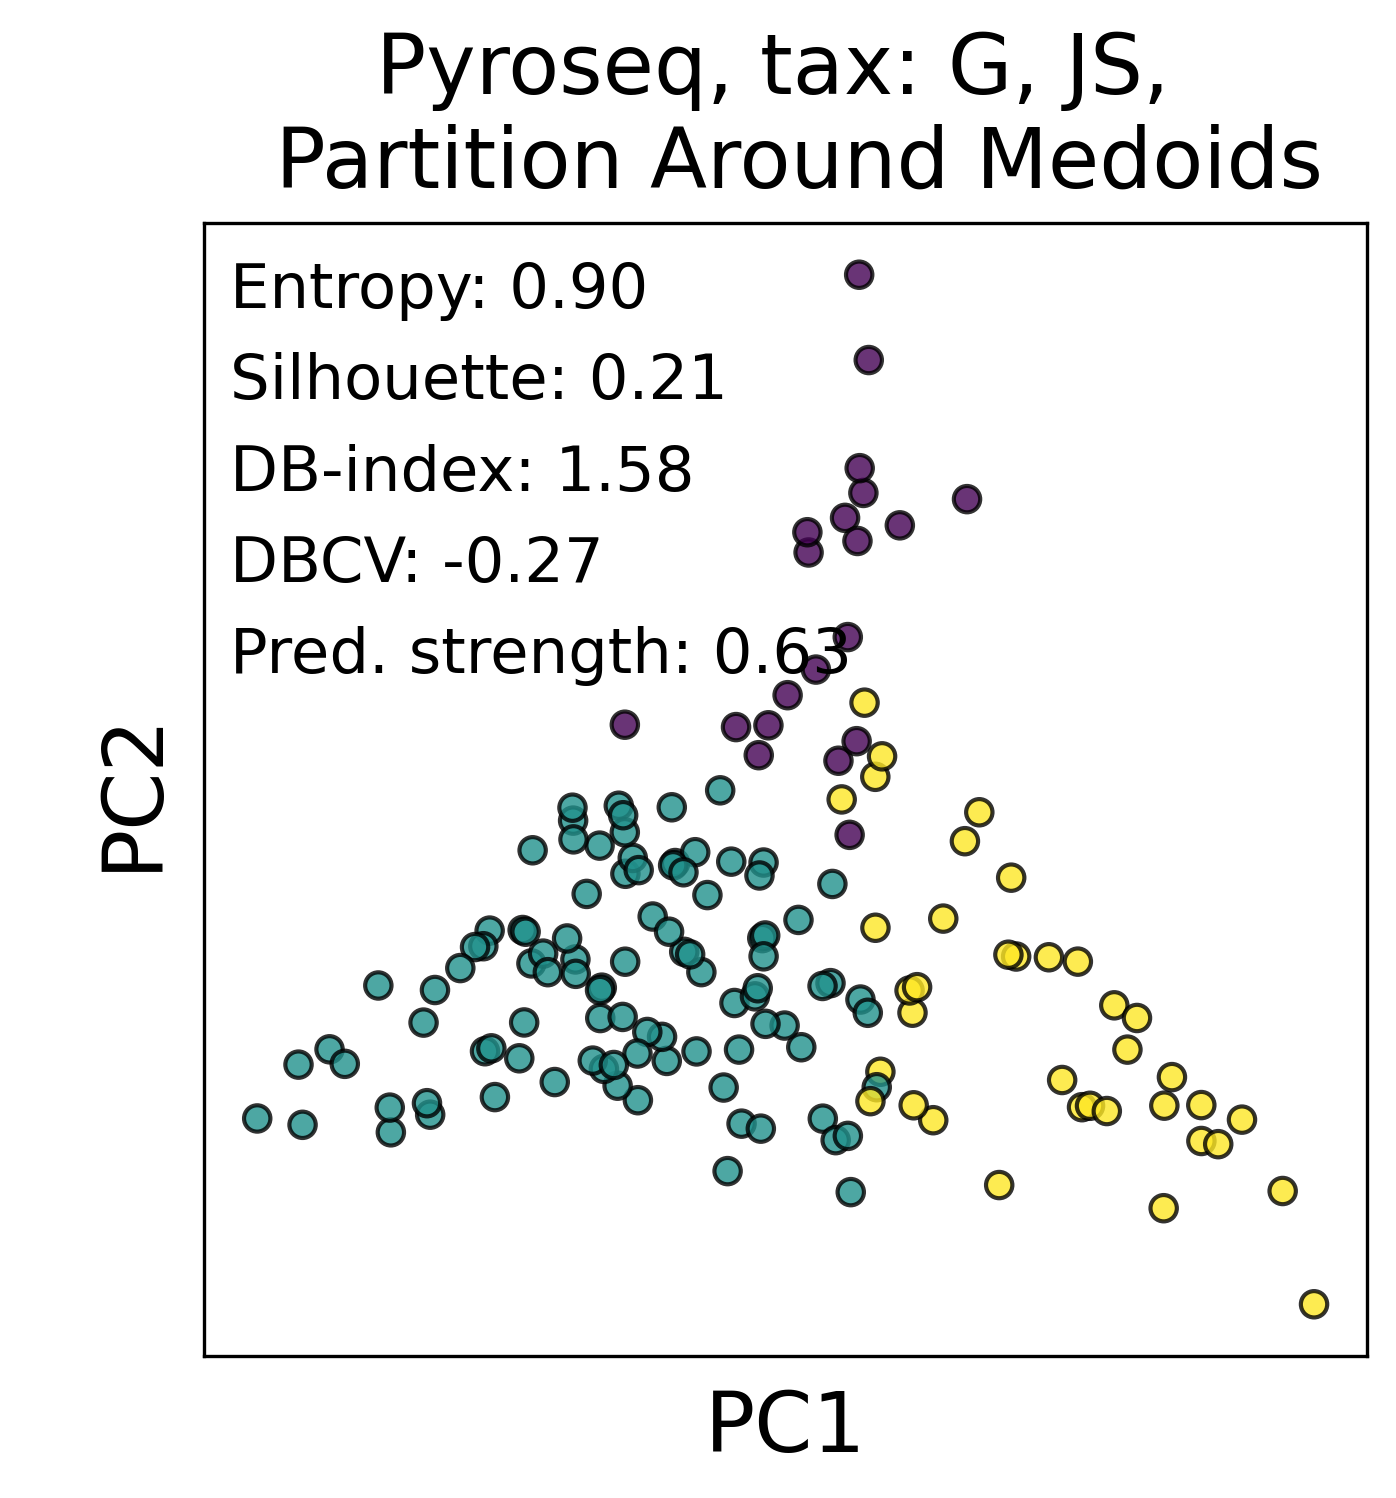

In [35]:
locs = {
    'Sanger_g':'best',
    'Illumina_g':(-0.15,0.57),
    'Pyroseq_g':(-0.15,0.57)
}

for label, results_label in results_JS_PAM.items():

    X = data_pca[label]
    y = results_label['labels']

    ent = results_label['entropy']
    silh = results_label['silh']
    dbind = results_label['dbind']
    dbcv = results_label['dbcv']
    ps = results_label['ps']

    plt.figure(figsize=(5,5), dpi=300)

    plt.scatter(
                X[:,0], 
                X[:,1],
                c=y,
                edgecolors='black',
                s=40,
                alpha=0.8,
               )

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.xticks([])
    plt.yticks([])
    
    plt.rcParams.update({'font.size': 20, 'axes.titley':1.05})
    
    handles, labels = plt.gca().get_legend_handles_labels()

    text_handle = mlines.Line2D([], [], color='none', label='Entropy: {:.2f}'.format(ent))
    handles.append(text_handle)

    text_handle = mlines.Line2D([], [], color='none', label='Silhouette: {:.2f}'.format(silh))
    handles.append(text_handle)

    text_handle = mlines.Line2D([], [], color='none', label='DB-index: {:.2f}'.format(dbind))
    handles.append(text_handle)

    text_handle = mlines.Line2D([], [], color='none', label='DBCV: {:.2f}'.format(dbcv))
    handles.append(text_handle)

    text_handle = mlines.Line2D([], [], color='none', label='Pred. strength: {:.2f}'.format(ps))
    handles.append(text_handle)


    # Add the arbitrary information patch to the legend handles
    legend = plt.legend(handles=handles, 
                        loc=locs[label], 
                        fontsize=15, 
                        frameon=True, 
                        fancybox=True, 
                        framealpha=0.0)
    
    dataset_name = label.split('_')[0]
    plt.title(f'{dataset_name}, tax: G, JS, \n Partition Around Medoids', fontsize=20, y=1.01)
    
    plt.show()

# Dist clust

In [127]:

methods_dict_distances = {
                           'HDBSCAN':[HDBSCAN, 
                              {
                               'min_cluster_size':list(range(4,30)), 
                                  'alpha':[0.01, 0.5, 1., 1.5, 2.0],
                               'cluster_selection_epsilon': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
                              'min_samples':[None]+list(range(2,10)),
                               'metric':['precomputed'],
                               'core_dist_n_jobs':[1],
                               'random_state':[42]}
                               ],
                           'KMedoids':[KMedoids, 
                                       {'n_clusters':np.arange(2, 10, 1),
                                        'method':['pam'],
                                        'metric':['precomputed'],
                                        'init':['k-medoids++'],
                                        'random_state':[42]}],
                           'SpectralClustering':[SpectralClustering_prec, 
                                                 {'n_clusters':np.arange(2, 10, 1), 
                                                  'gamma': np.linspace(1,7,num=10),
                                                  'eigen_tol':[1e-4]}]
                        }

In [129]:
for distance_name, distance_dict in tqdm(distances_orig.items()):
    
    results_path = os.path.join(clustering_results_root, f'{distance_name}_cluster_results')
    
    if os.path.isfile(results_path + '.npy'):
        print(f'{results_path} exists, skipping...')
        continue
    
    distance_cluster_results = defaultdict(dict)
    
    '''
    list of dicts [
                  dataset_1 ->  {'method1':[partition1, partition2], ...}
                    , ...., 
                  dataset_n ->  {'method1':[partition1, partition2], ...}
                  ]
    
    '''
    clustering_data_results = Parallel(n_jobs=len(distance_dict),
                                       mmap_mode='w+')(delayed(clustering_by_methods)(data.astype('double'), 
                                                                                      methods_dict_distances,
                                                                                      precomputed=True,
                                                                                      d=data_orig[label].shape[1],
                                                                                      cluster_perc_threshold=CPT)
                                                            for label, data in distance_dict.items())

    # create compatible metrics dicts
    for i,label in enumerate(distance_dict.keys()):
        for j, method_name in enumerate(methods_dict_distances.keys()):
            distance_cluster_results[label][method_name] = clustering_data_results[i][method_name]

    np.save(results_path, distance_cluster_results)
    
clear_output()

# Clustering: PCA

In [130]:
methods_dict = {
               'HDBSCAN':[HDBSCAN, 
                  {
                   'min_cluster_size':list(range(4,30)), 
                   'alpha':[0.01, 0.5, 1., 1.5, 2.0],
                   'cluster_selection_epsilon': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
                  'min_samples':[None]+list(range(2,30)),
                   'core_dist_n_jobs':[1]}
                   ],
               'KMedoids':[KMedoids, 
                           {'n_clusters':np.arange(2, 10, 1),
                            'method':['pam'],
                            'init':['k-medoids++'],
                            'random_state':[42]}],
               'SpectralClustering':[SpectralClustering, 
                                     {'n_clusters':np.arange(2, 10, 1),
                                      'affinity':['nearest_neighbors'],
                                      'n_neighbors': list(range(1,30,2)), 
                                     'eigen_tol':[1e-4],
                                     'random_state':[42]}]
             }

In [131]:
results_path = os.path.join(clustering_results_root, f'pca_cluster_results')

pca_cluster_results = defaultdict(dict)

clustering_data_results = Parallel(n_jobs=len(data_pca),
                                   mmap_mode='w+')(delayed(clustering_by_methods)(data.astype('double'), 
                                                                                  methods_dict,
                                                                                  precomputed=False,
                                                                                  d=data.shape[1],
                                                                                  cluster_perc_threshold=CPT)
                                                        for label, data in data_pca.items())

# create compatible metrics dicts
for i,label in enumerate(data_pca.keys()):
    for j, method_name in enumerate(methods_dict.keys()):
        pca_cluster_results[label][method_name] = clustering_data_results[i][method_name]

np.save(results_path, pca_cluster_results)

clear_output()

# Load clustering results

In [36]:
# ['lle', 'L1', 'pca', ...]
representations_names = np.unique(list(map(lambda x: x.split('_')[0], os.listdir(clustering_results_root))))

clustering_results_df = []

for representation in representations_names:
    
    clustreing_results_path = os.path.join(clustering_results_root, f'{representation}_cluster_results.npy')
    cluster_results = np.load(clustreing_results_path, allow_pickle=True).item()
    
    # results for each datset
    for label, cl_res_label in cluster_results.items():
        #results for each method given dataset
        for cl_method, cl_res_label_method in cl_res_label.items():
            
            if len(cl_res_label_method) == 0:
                print('Empty results for:', representation, label, cl_method)
                continue
                
            df = pd.DataFrame(cl_res_label_method)
            
#             cl_res_label_method_ = {k:v[0] for k,v in cl_res_label_method.items()}
#             df = pd.DataFrame(cl_res_label_method_).T
            
            dataset, tax = label.split('_')
            
            df['dataset'] = dataset
            df['tax'] = tax
            df['representation'] = representation
            df['cl_method'] = cl_method
            # n_clusters found
            n_unique = lambda x: len(np.unique(x[x!=-1]))
            df['n_cl'] = df['labels'].apply(n_unique)
            
            clustering_results_df.append(df)
            
clustering_results_df = pd.concat(clustering_results_df, axis=0, ignore_index=True)

Empty results for: pca Sanger_g HDBSCAN
Empty results for: pca Illumina_g HDBSCAN


In [37]:
df_mask = (clustering_results_df['data_used'] > DATA_PRESERVED_THRESHOLD) &\
          (clustering_results_df['dbind'] < DBIND_MAX)  &\
          (~clustering_results_df['dbcv'].isna())

clustering_results_df_ = clustering_results_df[df_mask]

# Davies-Bouldin index and Silhoutte score, entropy coloring

In [56]:
nice_repr = {'tsne':'t-SNE',
             'umap':'UMAP',
             'spectral':'SE',
             'L2':'L2'}

nice_cl = {'SpectralClustering':'Spectral cl.',
           'HDBSCAN':'HDBSCAN'}

## Sanger

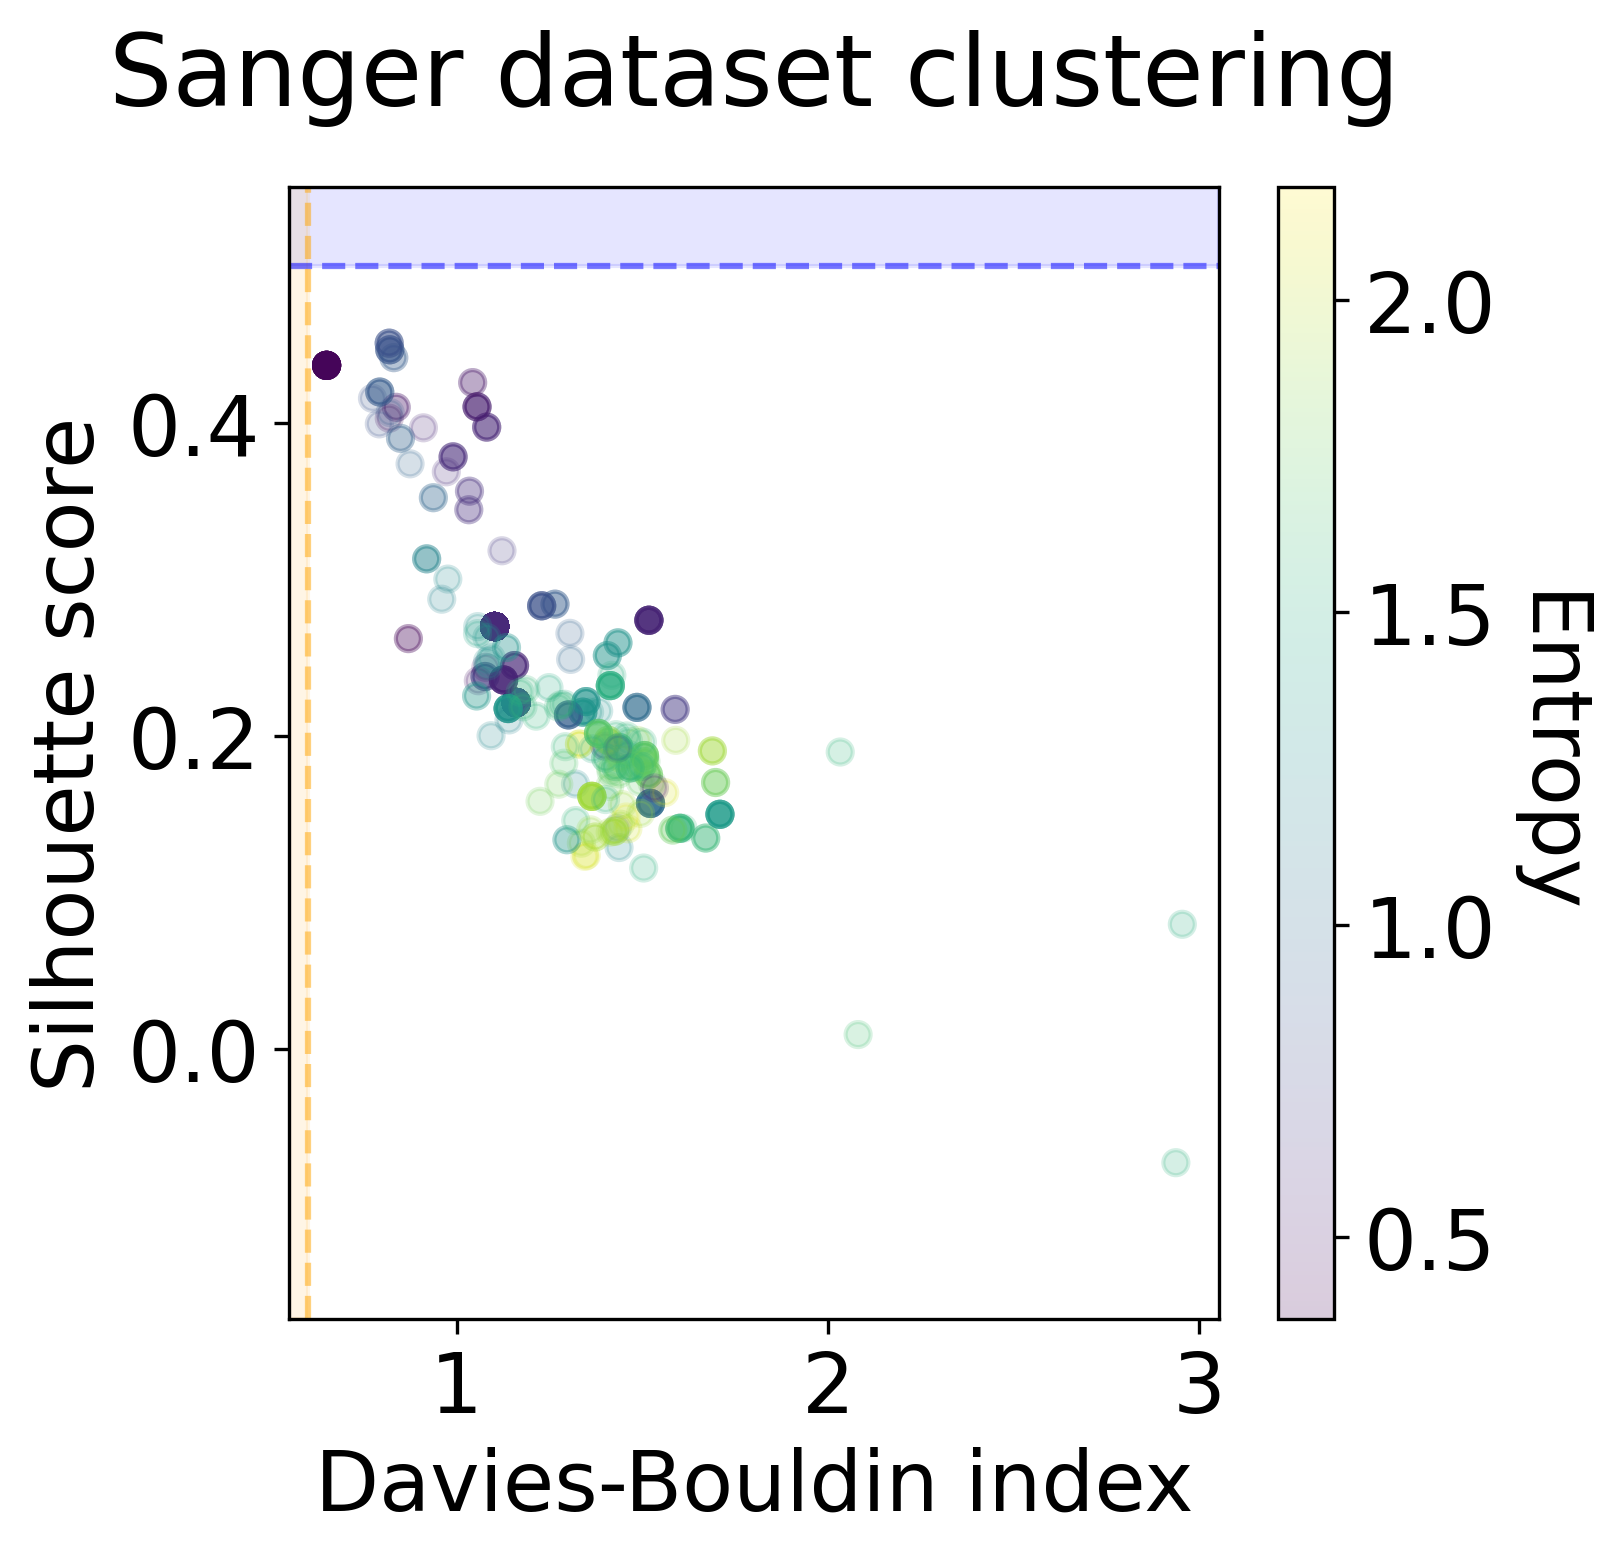

In [57]:

plt.rcParams.update({'font.size': 20, 'axes.titley':1.05})

Sanger_df_silh = clustering_results_df_.query('dataset == "Sanger"')

plot_clustering_scatter(Sanger_df_silh, 
                        x_metric_name='dbind',
                        y_metric_name='silh', 
                        coloring_metric_name='entropy', 
                        title='Sanger dataset clustering',
                        y_threshold=SILHOUETTE_THRESH,
                        x_threshold=DBIND_THRESHOLD,
                        y_hue_line=1,
                        x_hue_line=0)

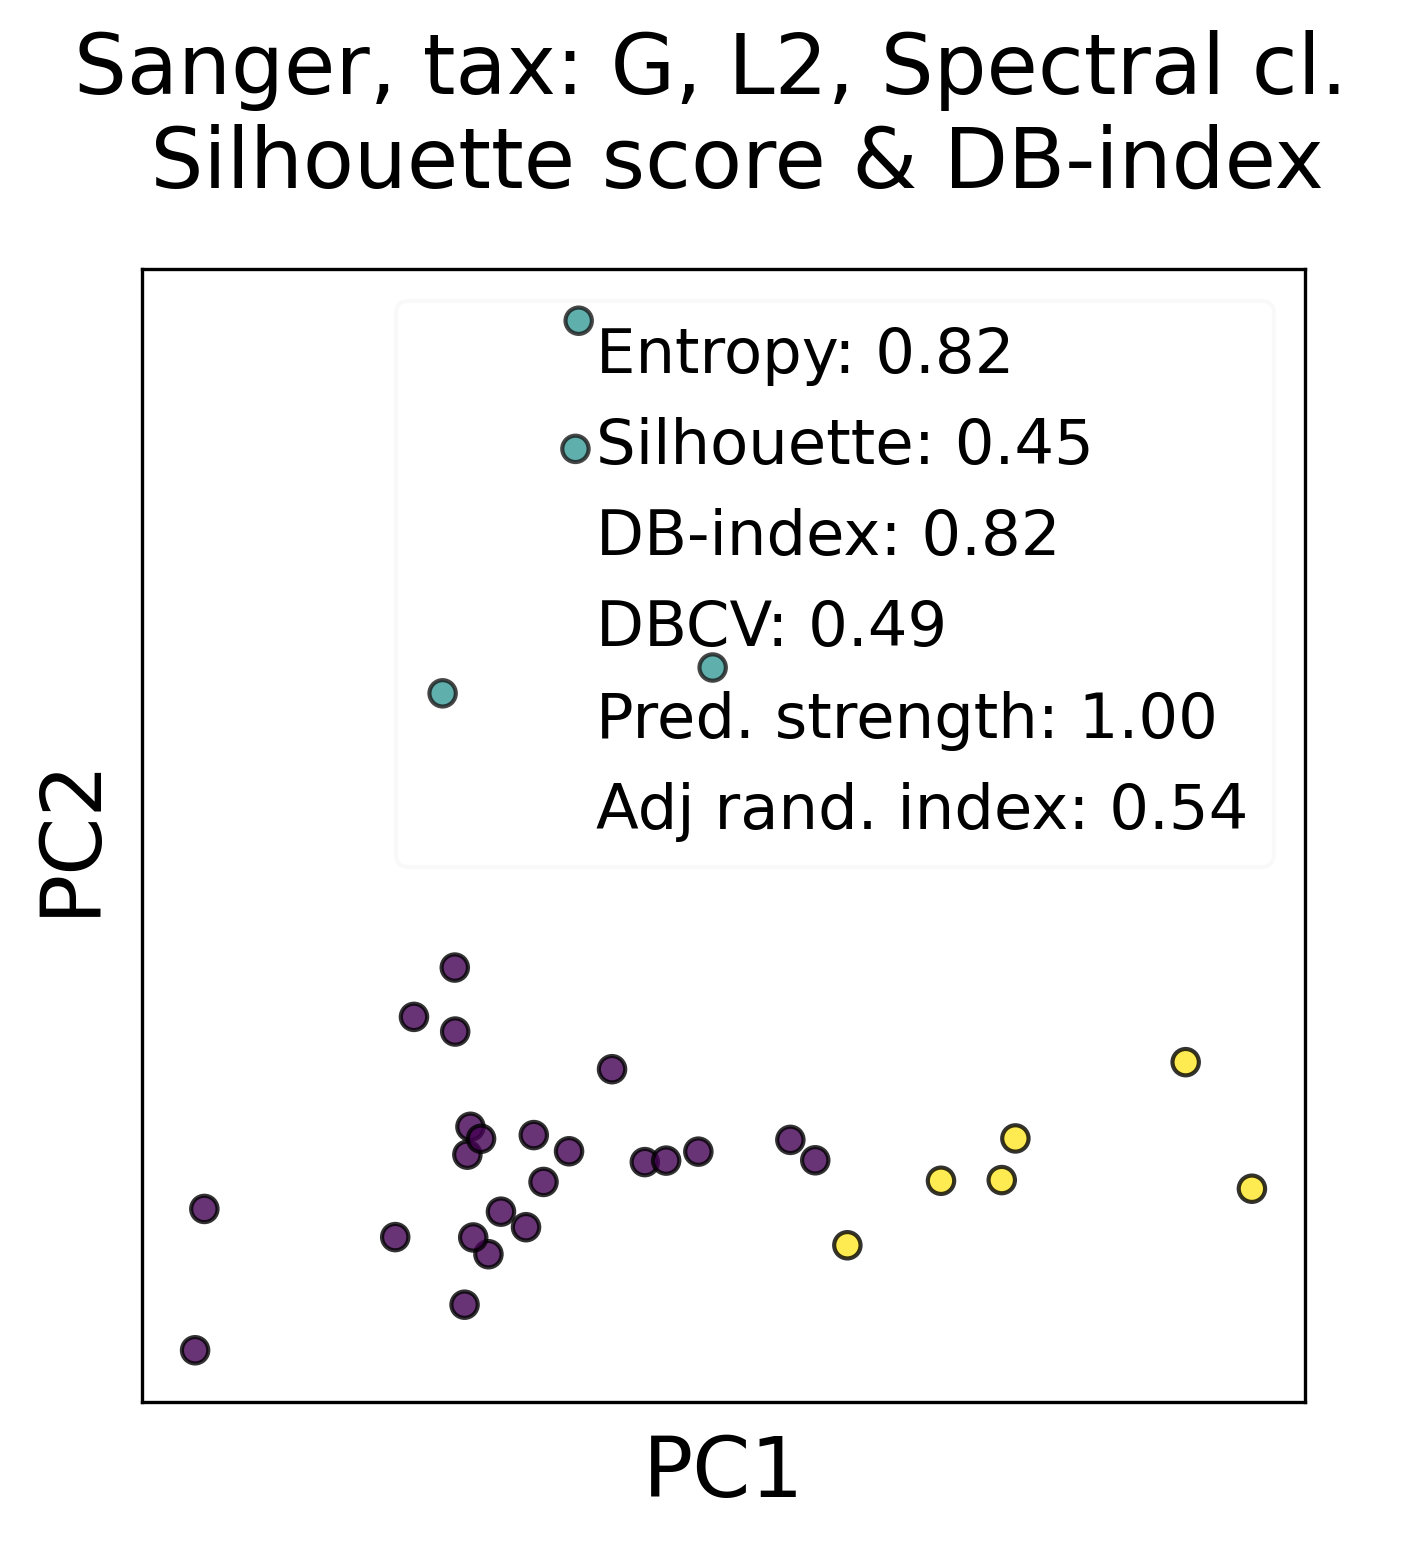

In [58]:
df_selected = Sanger_df_silh

idx = (df_selected['silh']).idxmax() 
best_clustering = df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']

X = data_pca['Sanger_g'][:,:2][df_mask]

ent, silh, dbind, dbcv, ps = np.array(best_clustering[['entropy', 'silh', 'dbind', 'dbcv', 'ps']].values, 
                                          dtype=np.float32).round(2)

RI = adjusted_rand_score(results_JS_PAM['Sanger_g']['labels'][df_mask], y)

plt.figure(figsize=(5,5), dpi=300)

plt.scatter(
            coord_to_pix(X[:,0]), 
            coord_to_pix(X[:,1]),
            c=y,
            edgecolors='black',
            s=40,
            alpha=0.8,
           )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])

handles, labels = plt.gca().get_legend_handles_labels()

text_handle = mlines.Line2D([], [], color='none', label='Entropy: {:.2f}'.format(ent))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Silhouette: {:.2f}'.format(silh))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DB-index: {:.2f}'.format(dbind))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DBCV: {:.2f}'.format(dbcv))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Pred. strength: {:.2f}'.format(ps))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Adj rand. index: {:.2f}'.format(RI))
handles.append(text_handle)

# Add the arbitrary information patch to the legend handles
legend = plt.legend(handles=handles, 
                    loc='best', 
                    fontsize=15, 
                    frameon=True, 
                    fancybox=True, 
                    framealpha=0.1)

X_REP = nice_repr[X_repr]
X_CL = nice_cl[X_cl_method]

plt.title(f'Sanger, tax: G, {X_REP}, {X_CL} \n Silhouette score & DB-index', fontsize=20)
plt.show()

## Illumina

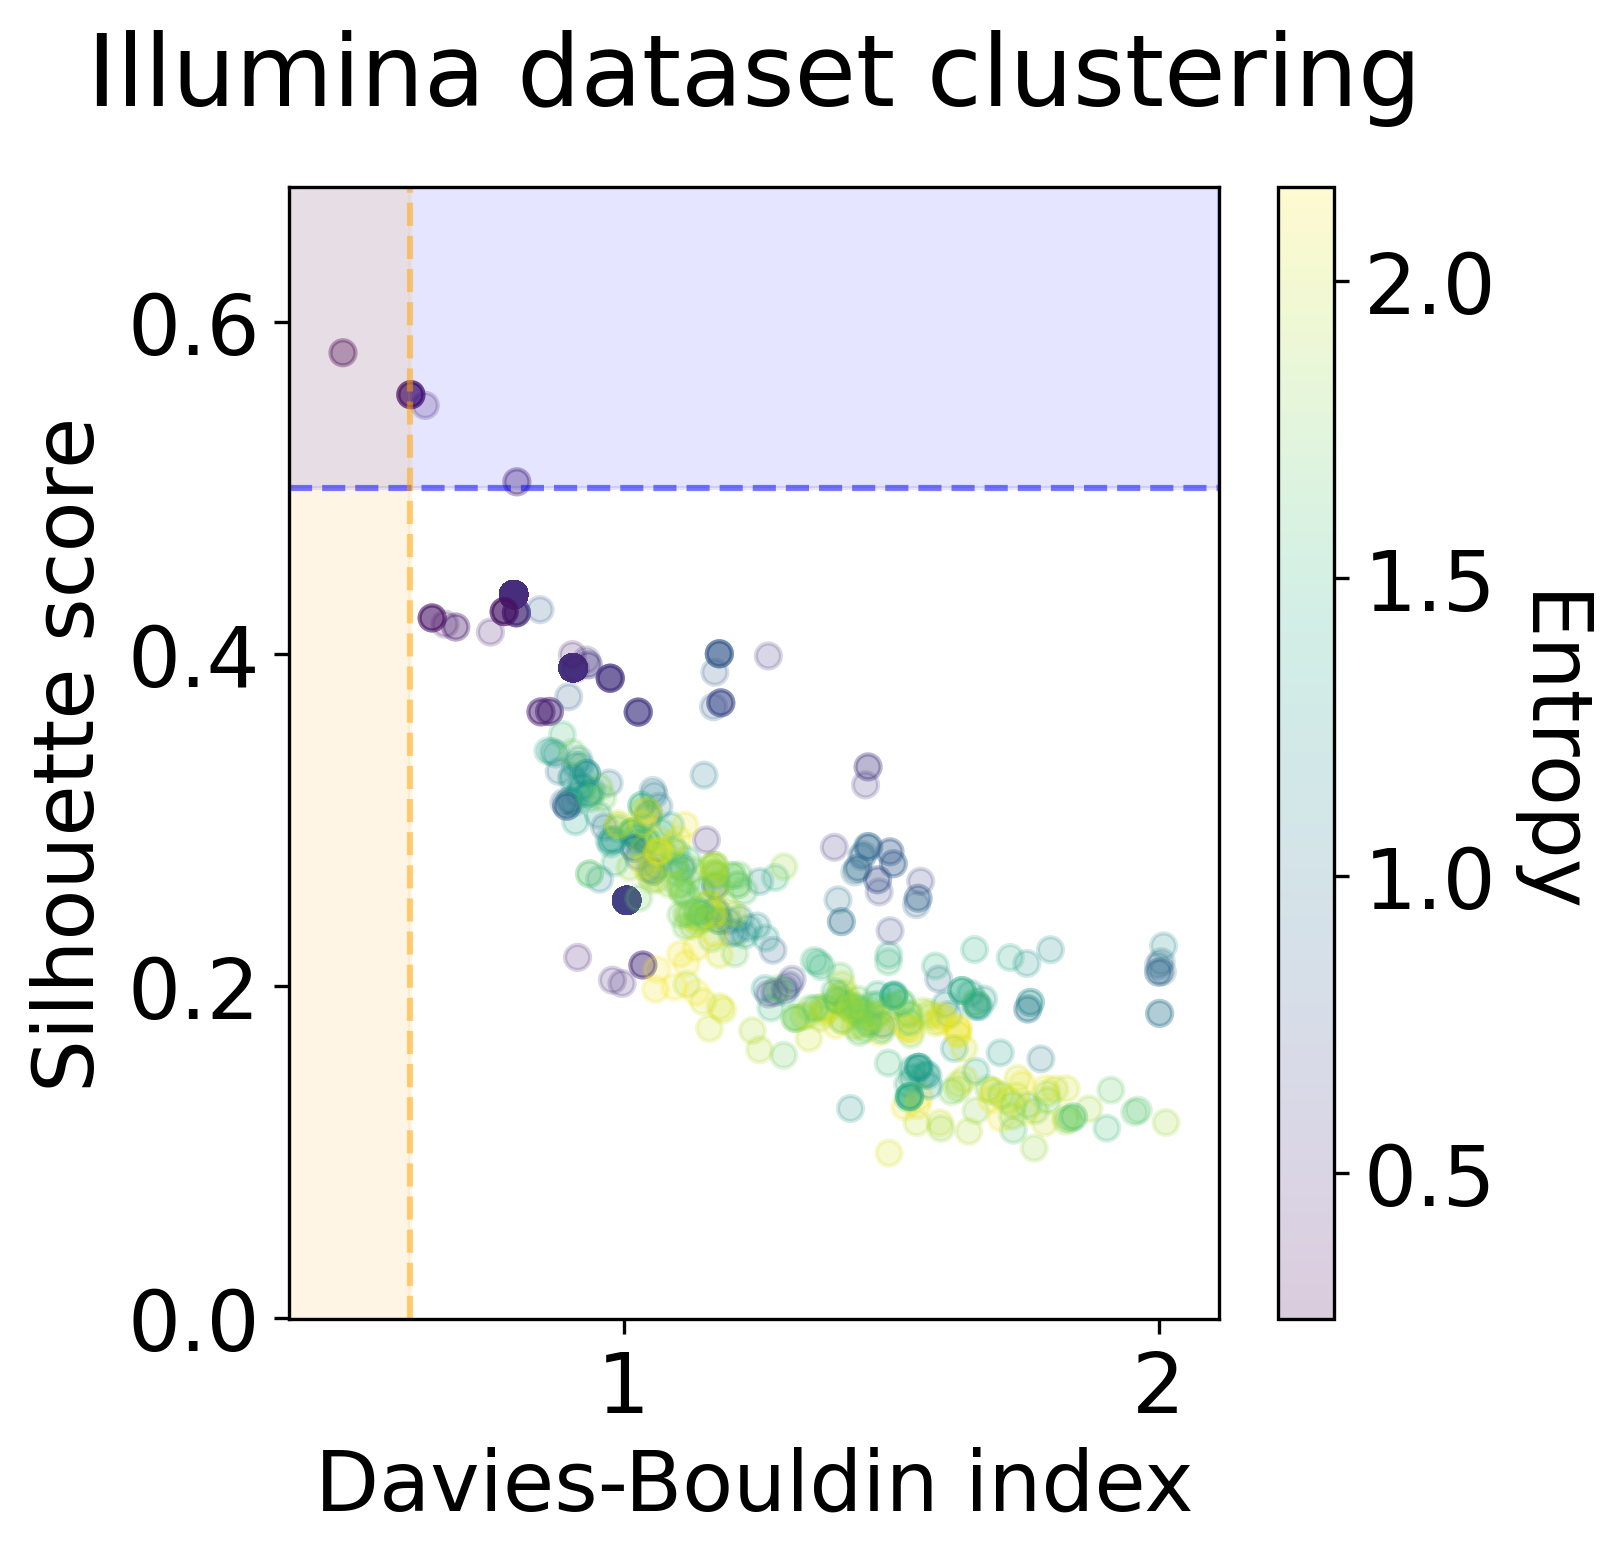

In [59]:
Illumina_df = clustering_results_df_.query('dataset == "Illumina"')

plot_clustering_scatter(Illumina_df, 
                        x_metric_name='dbind',
                        y_metric_name='silh', 
                        coloring_metric_name='entropy', 
                        title='Illumina dataset clustering',
                        y_threshold=SILHOUETTE_THRESH,
                        x_threshold=DBIND_THRESHOLD,
                        y_hue_line=1,
                        x_hue_line=0)

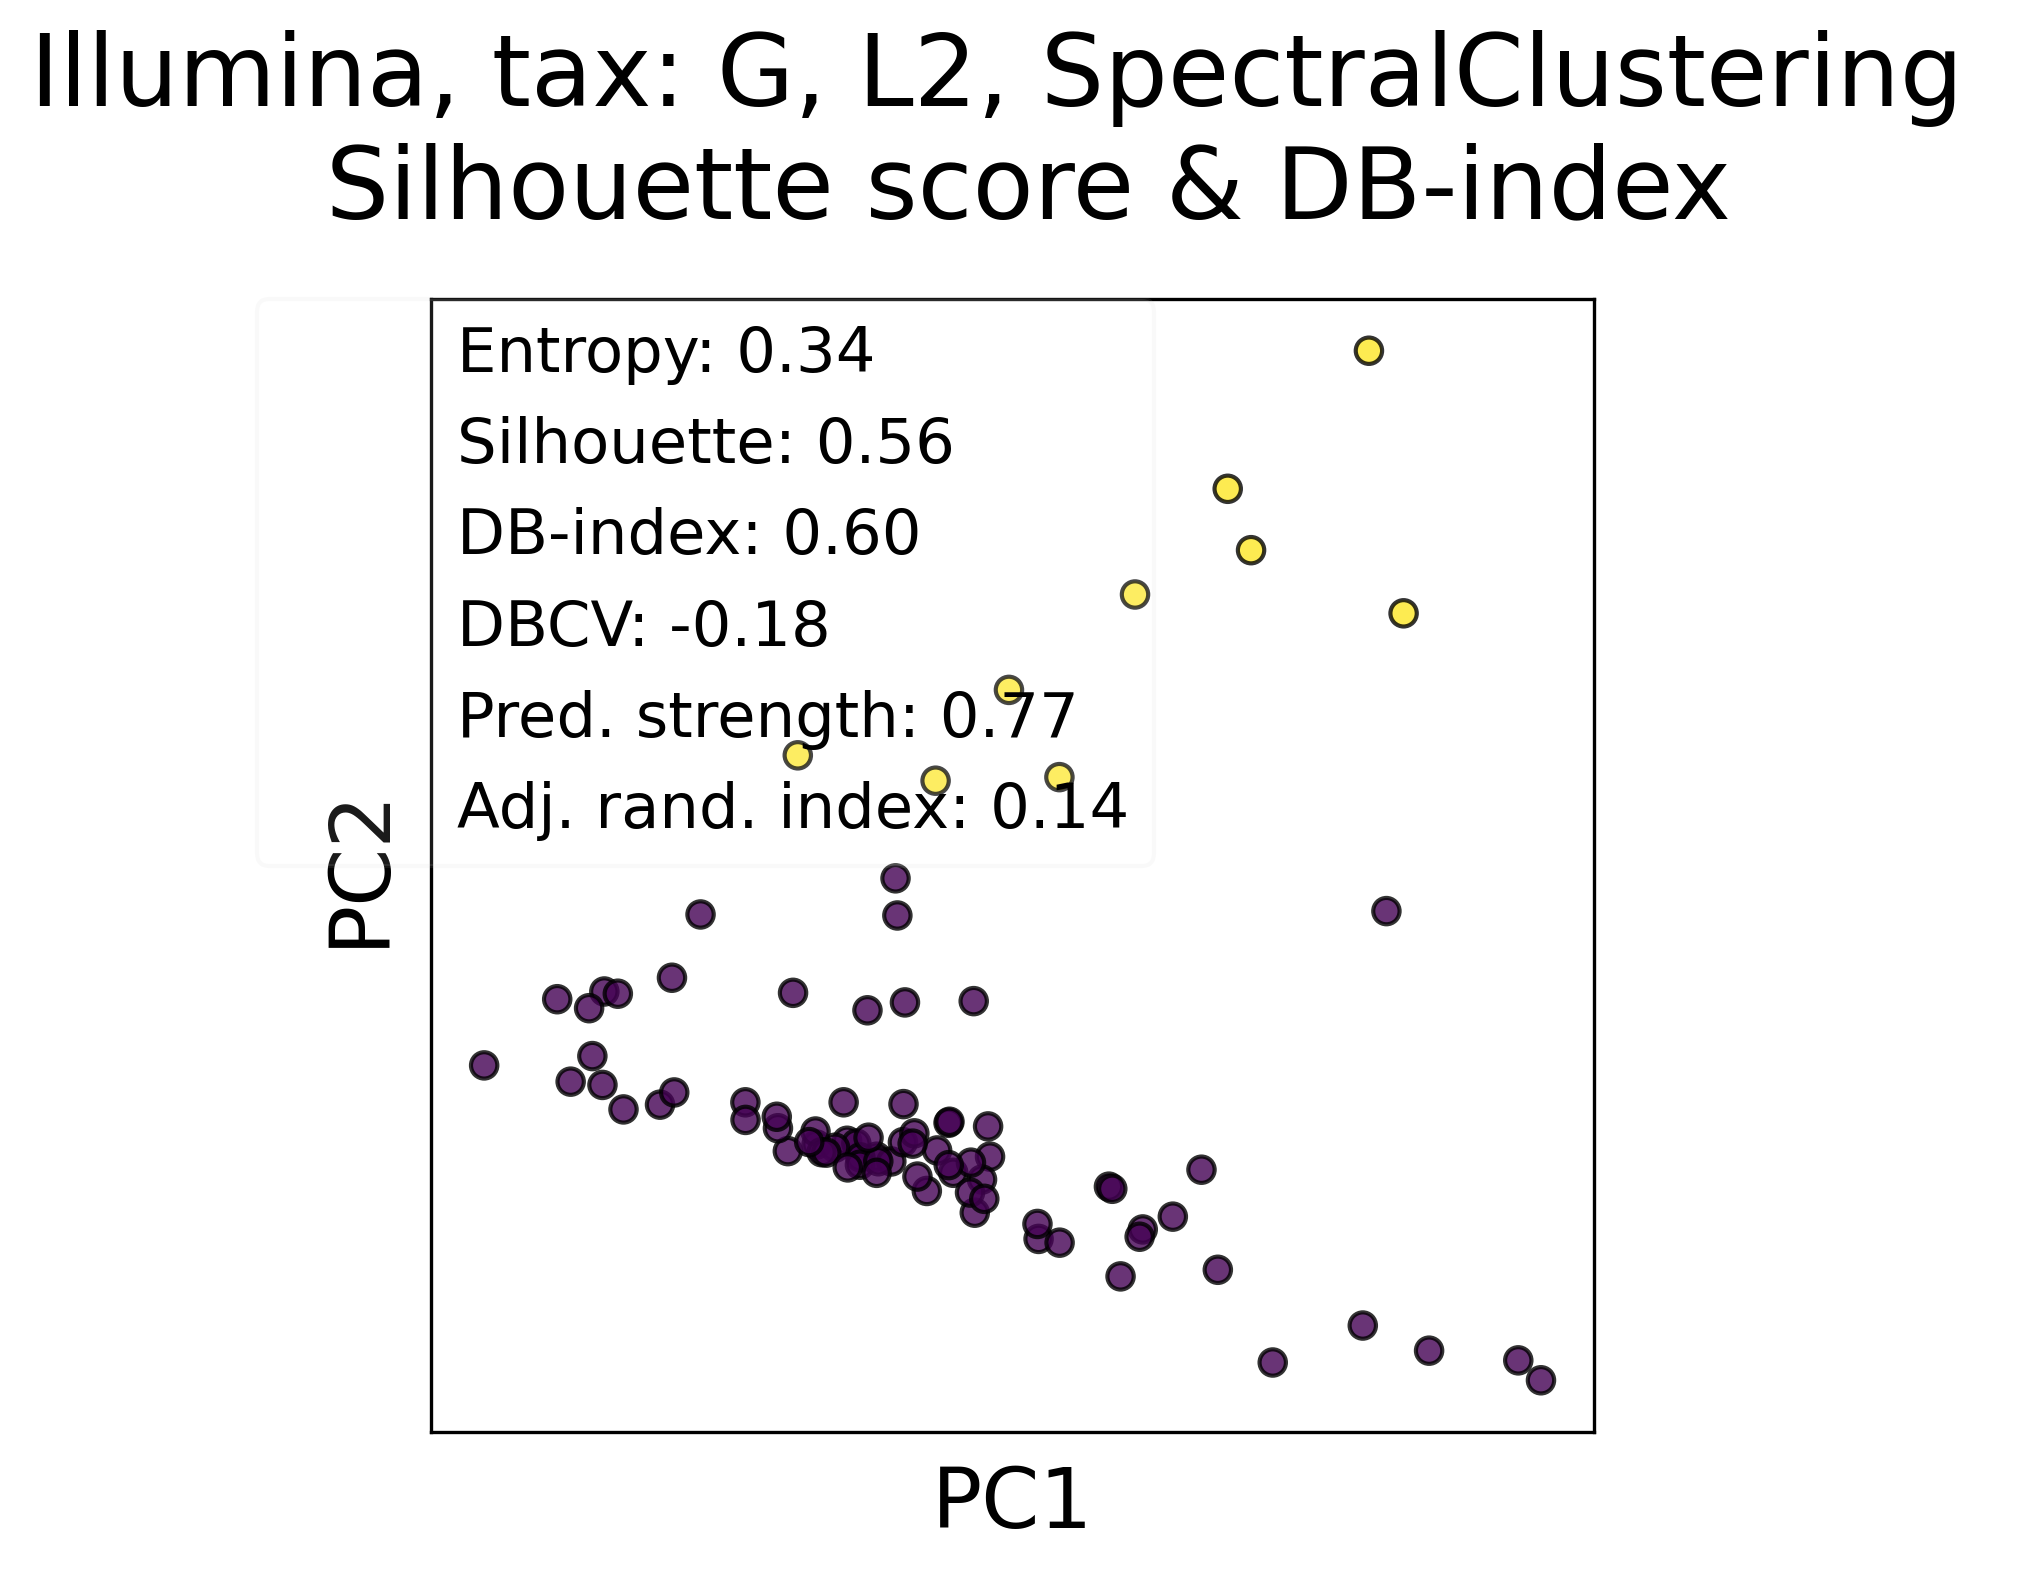

In [60]:
df = Illumina_df
selection_mask_df = (df['silh'] >= SILHOUETTE_THRESH-5e-3) * (df['dbind'] <= DBIND_THRESHOLD+5e-3)
df_selected = df[selection_mask_df]
idx = df_selected['entropy'].idxmax()

best_clustering = df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']

X = data_pca['Illumina_g'][:,:2][df_mask]

ent, silh, dbind, dbcv, ps = np.array(best_clustering[['entropy', 'silh', 'dbind', 'dbcv', 'ps']].values, 
                                          dtype=np.float32).round(2)

RI = adjusted_rand_score(results_JS_PAM['Illumina_g']['labels'], y)

plt.figure(figsize=(5,5), dpi=300)

plt.scatter(
            coord_to_pix(X[:,0]), 
            coord_to_pix(X[:,1]),
            c=y,
            edgecolors='black',
            s=40,
            alpha=0.8,
           )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])

handles, labels = plt.gca().get_legend_handles_labels()

text_handle = mlines.Line2D([], [], color='none', label='Entropy: {:.2f}'.format(ent))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Silhouette: {:.2f}'.format(silh))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DB-index: {:.2f}'.format(dbind))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DBCV: {:.2f}'.format(dbcv))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Pred. strength: {:.2f}'.format(ps))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Adj. rand. index: {:.2f}'.format(RI))
handles.append(text_handle)

# Add the arbitrary information patch to the legend handles
legend = plt.legend(handles=handles, 
                    loc=(-0.15,0.5), 
                    fontsize=15, 
                    frameon=True, 
                    fancybox=True, 
                    framealpha=0.1)

plt.title(f'Illumina, tax: G, {X_repr.upper()}, {X_cl_method} \n Silhouette score & DB-index')
plt.show()

## Pyroseq

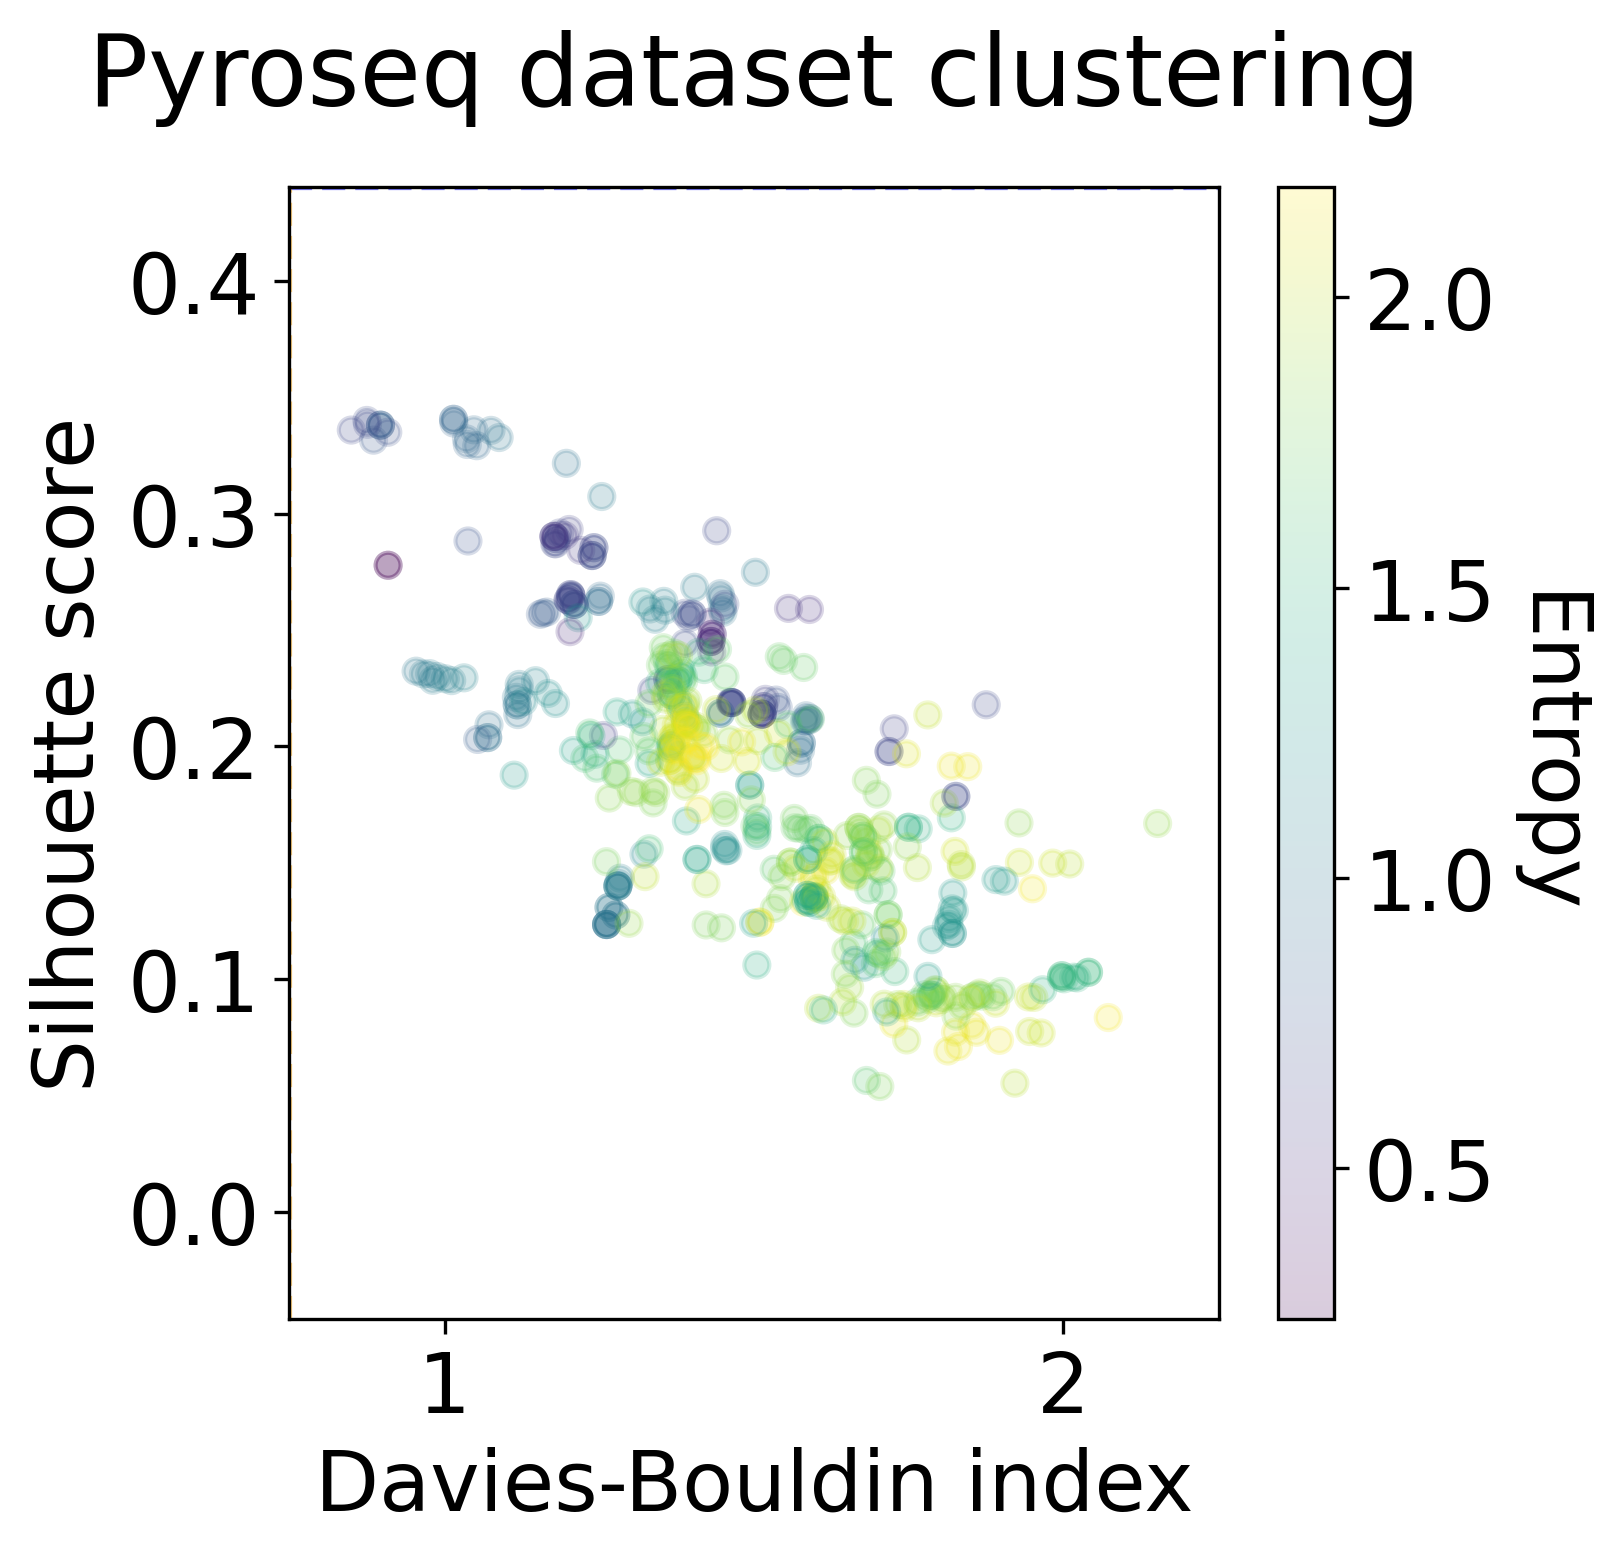

In [61]:
Pyroseq_df = clustering_results_df_.query('dataset == "Pyroseq"')

plot_clustering_scatter(Pyroseq_df, 
                        x_metric_name='dbind',
                        y_metric_name='silh', 
                        coloring_metric_name='entropy', 
                        title='Pyroseq dataset clustering',
                        y_threshold=SILHOUETTE_THRESH,
                        x_threshold=DBIND_THRESHOLD,
                        y_hue_line=1,
                        x_hue_line=0)

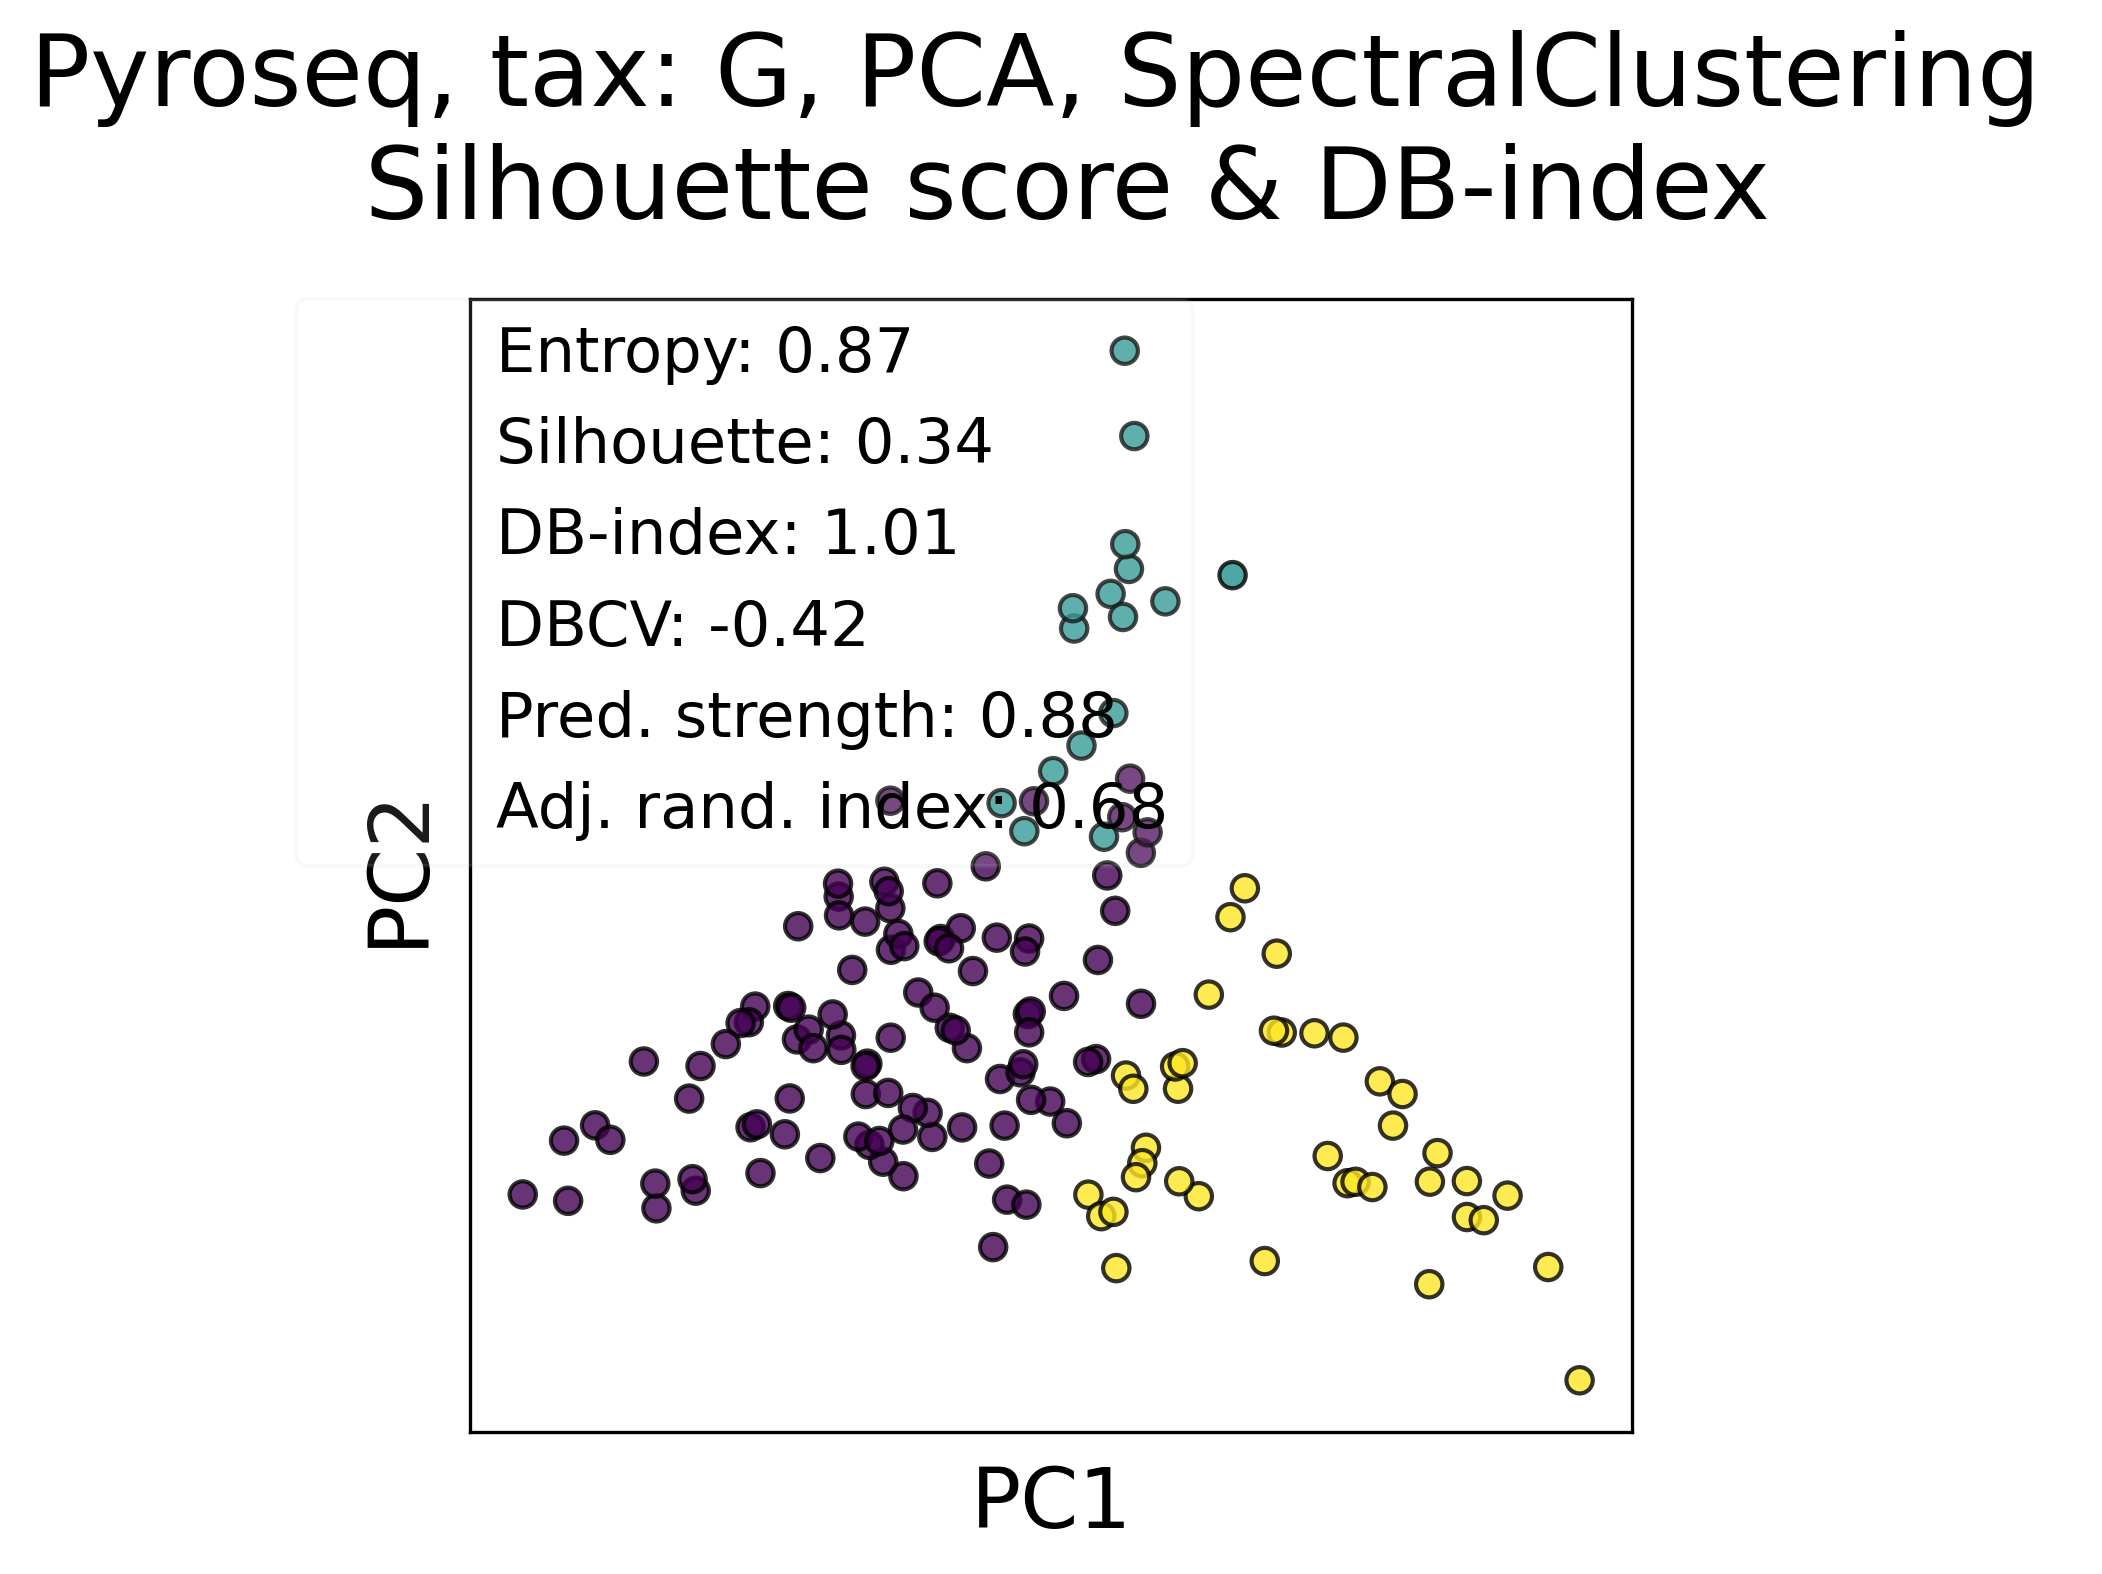

In [62]:
df_selected = Pyroseq_df
idx = (df_selected['silh']).idxmax() 

best_clustering = df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']

X = data_pca['Pyroseq_g'][:,:2][df_mask]

ent, silh, dbind, dbcv, ps = np.array(best_clustering[['entropy', 'silh', 'dbind', 'dbcv', 'ps']].values, 
                                          dtype=np.float32).round(2)



RI = adjusted_rand_score(results_JS_PAM['Pyroseq_g']['labels'], y)

plt.figure(figsize=(5,5), dpi=300)

plt.scatter(
            coord_to_pix(X[:,0]), 
            coord_to_pix(X[:,1]),
            c=y,
            edgecolors='black',
            s=40,
            alpha=0.8,
           )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])

handles, labels = plt.gca().get_legend_handles_labels()

text_handle = mlines.Line2D([], [], color='none', label='Entropy: {:.2f}'.format(ent))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Silhouette: {:.2f}'.format(silh))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DB-index: {:.2f}'.format(dbind))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DBCV: {:.2f}'.format(dbcv))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Pred. strength: {:.2f}'.format(ps))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Adj. rand. index: {:.2f}'.format(RI))
handles.append(text_handle)

# Add the arbitrary information patch to the legend handles
legend = plt.legend(handles=handles, 
                    loc=(-0.15,0.5), 
                    fontsize=15, 
                    frameon=True, 
                    fancybox=True, 
                    framealpha=0.1)

plt.title(f'Pyroseq, tax: G, {X_repr.upper()}, {X_cl_method} \n Silhouette score & DB-index')
plt.show()

# DBCV index and Prediction Strength

## Sanger

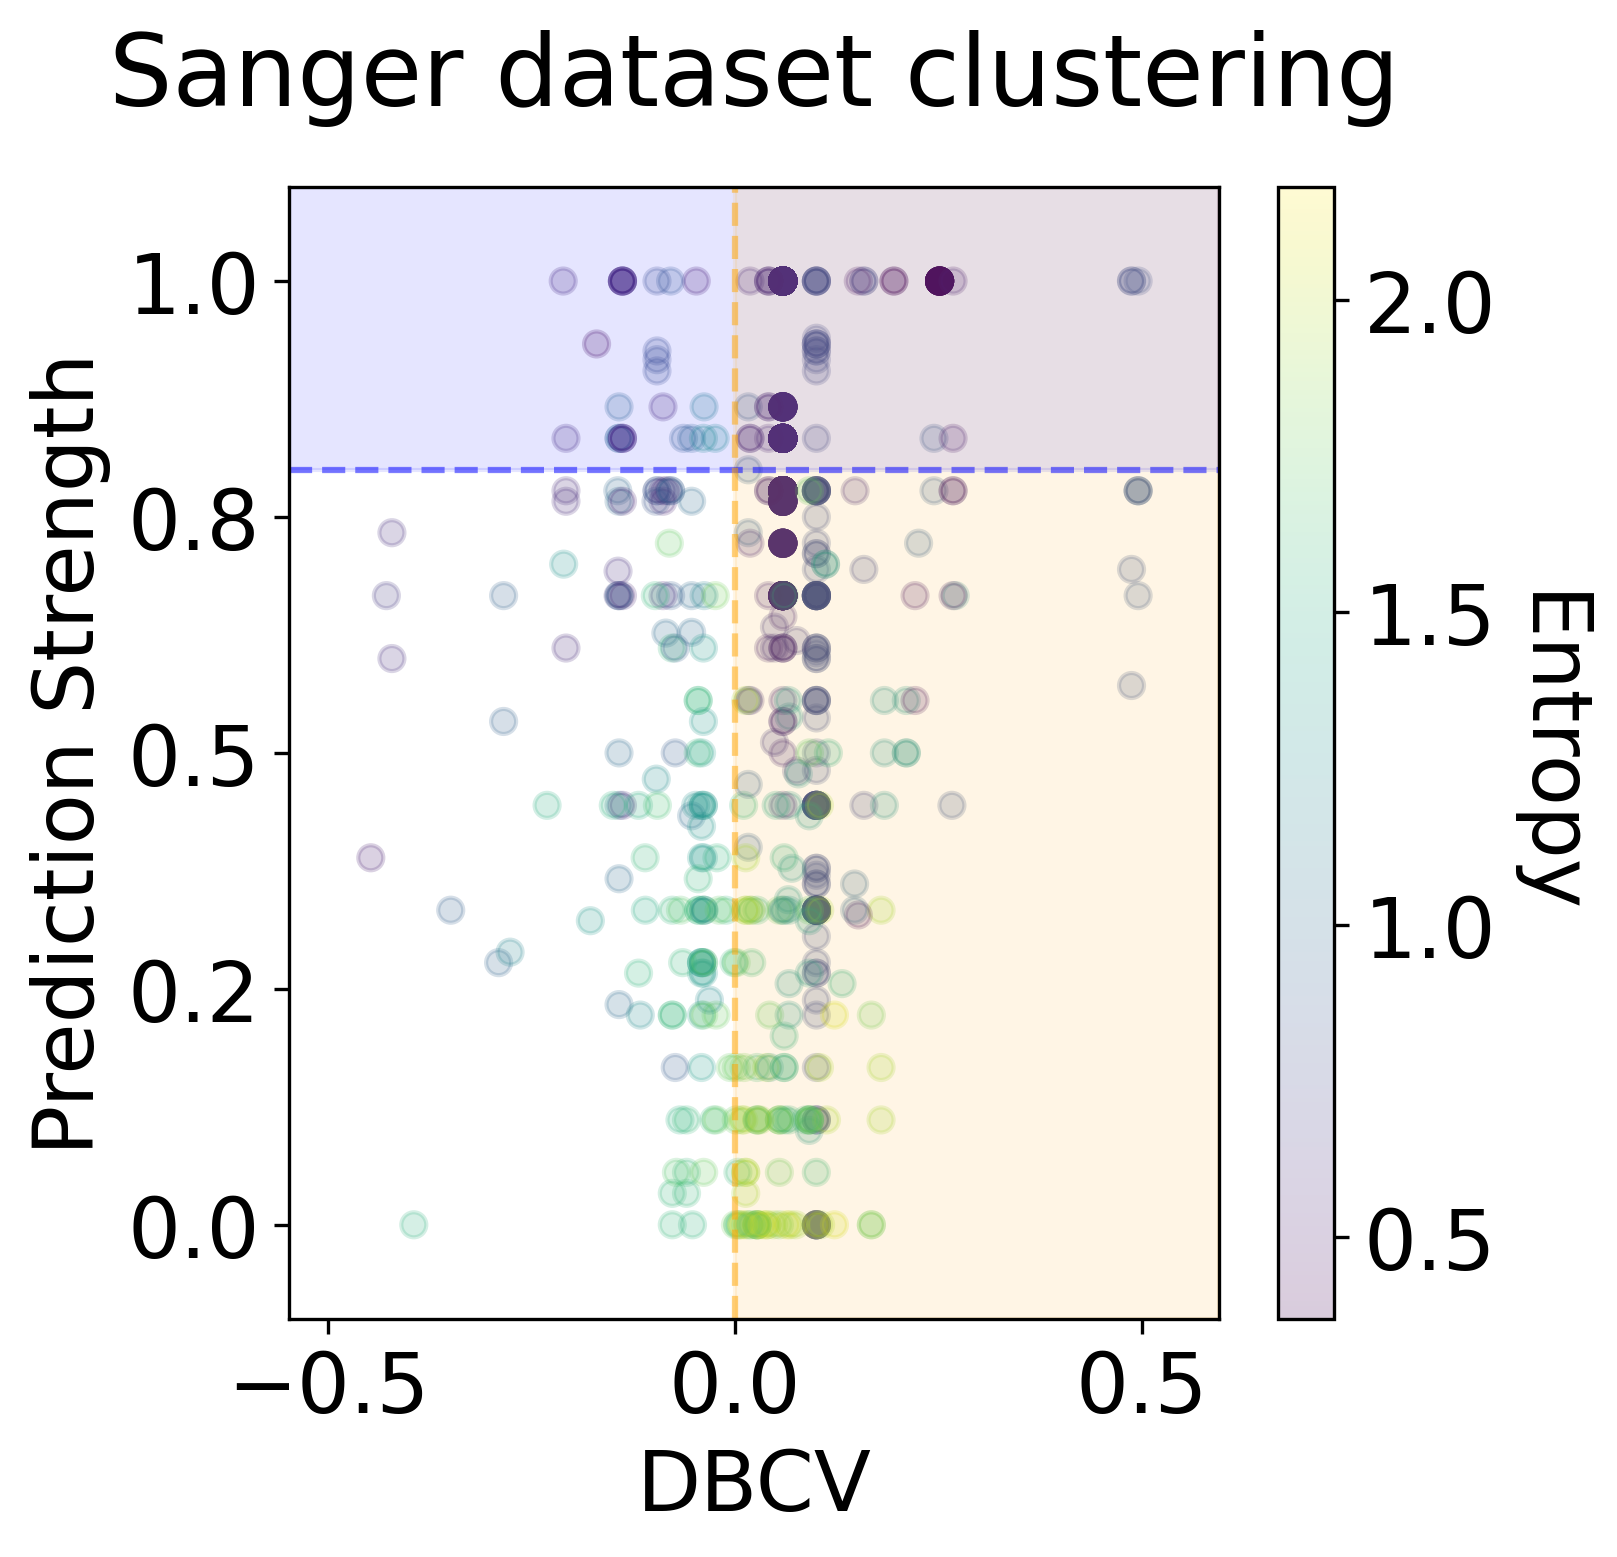

In [63]:
Sanger_df = clustering_results_df_.query('dataset == "Sanger"')

plot_clustering_scatter(Sanger_df, 
                        x_metric_name='dbcv',
                        y_metric_name='ps', 
                        coloring_metric_name='entropy', 
                        title='Sanger dataset clustering',
                        y_threshold=PS_THRESHOLD,
                        x_threshold=DBCV_THRESHOLD,
                        y_hue_line=1.2,
                        x_hue_line=1
                        )

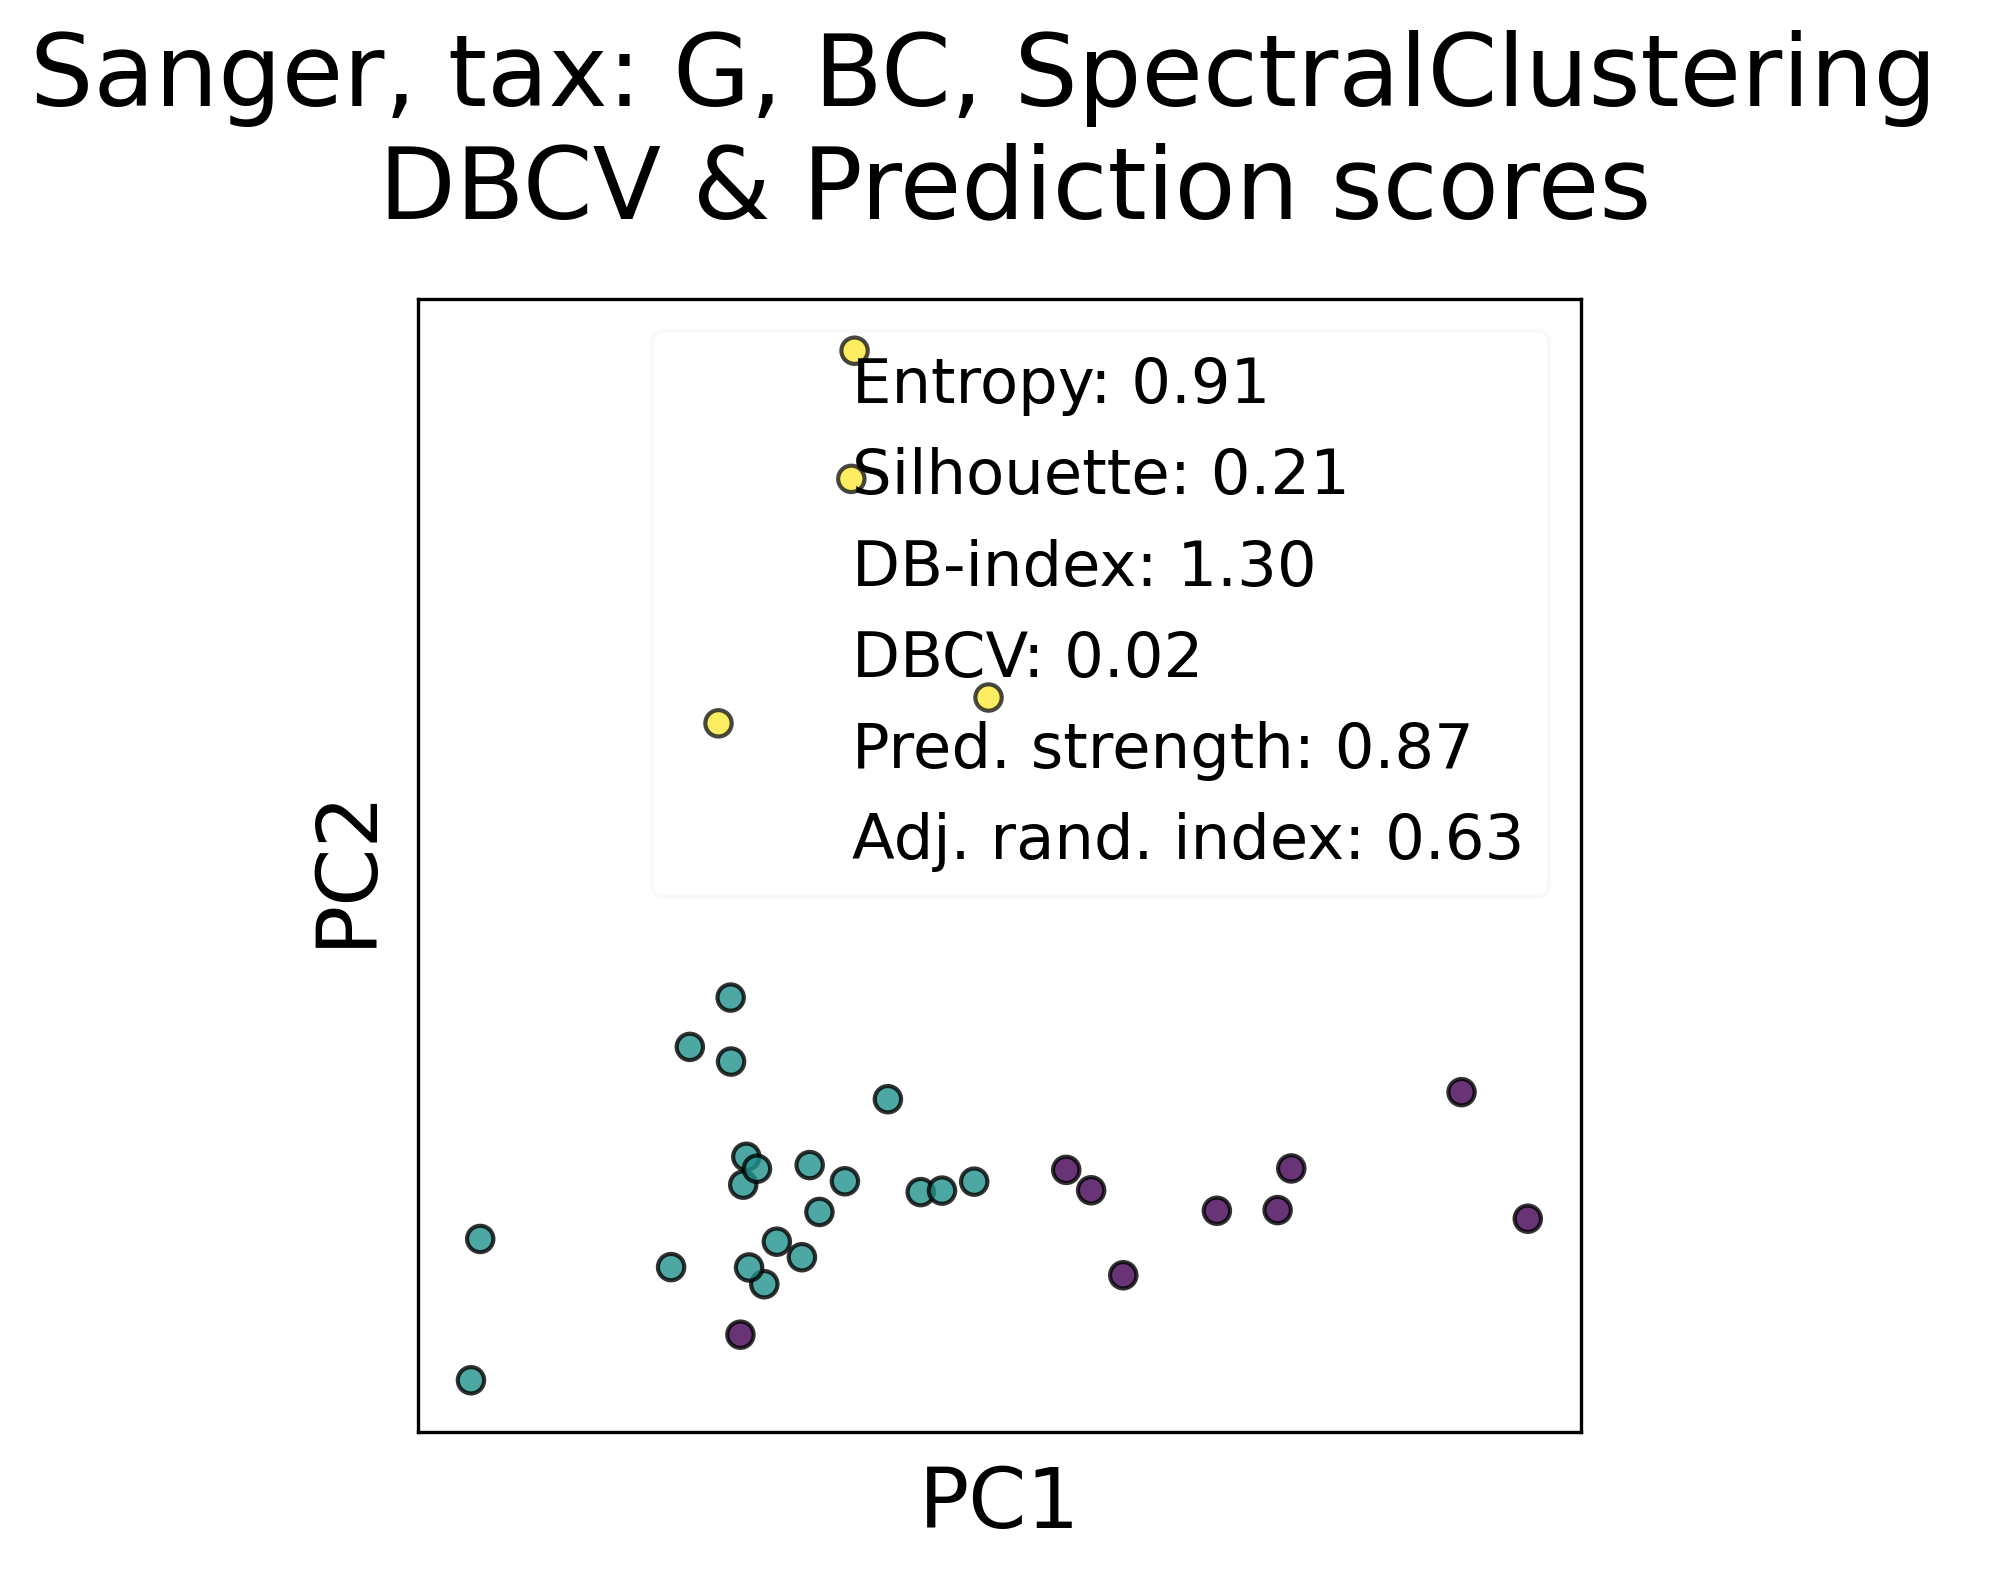

In [64]:
selection_mask_Sanger = (Sanger_df['dbcv'] > DBCV_THRESHOLD) * (Sanger_df['ps'] > PS_THRESHOLD)
df_selected = Sanger_df[selection_mask_Sanger]
idx = (df_selected['entropy']).idxmax()


best_clustering = df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']

X = data_pca['Sanger_g'][:,:2][df_mask]

RI = adjusted_rand_score(results_JS_PAM['Sanger_g']['labels'][df_mask], y)

ent, silh, dbind, dbcv, ps = np.array(best_clustering[['entropy', 'silh', 'dbind', 'dbcv', 'ps']].values, 
                                          dtype=np.float32).round(2)

plt.figure(figsize=(5,5), dpi=300)

plt.scatter(
            coord_to_pix(X[:,0]), 
            coord_to_pix(X[:,1]),
            c=y,
            edgecolors='black',
            s=40,
            alpha=0.8,
           )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])

handles, labels = plt.gca().get_legend_handles_labels()

text_handle = mlines.Line2D([], [], color='none', label='Entropy: {:.2f}'.format(ent))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Silhouette: {:.2f}'.format(silh))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DB-index: {:.2f}'.format(dbind))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DBCV: {:.2f}'.format(dbcv))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Pred. strength: {:.2f}'.format(ps))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Adj. rand. index: {:.2f}'.format(RI))
handles.append(text_handle)

# Add the arbitrary information patch to the legend handles
legend = plt.legend(handles=handles, 
                    loc='best', 
                    fontsize=15, 
                    frameon=True, 
                    fancybox=True, 
                    framealpha=0.1)

plt.title(f'Sanger, tax: G, {X_repr.upper()}, {X_cl_method} \n DBCV & Prediction scores')
plt.show()

## Illumina

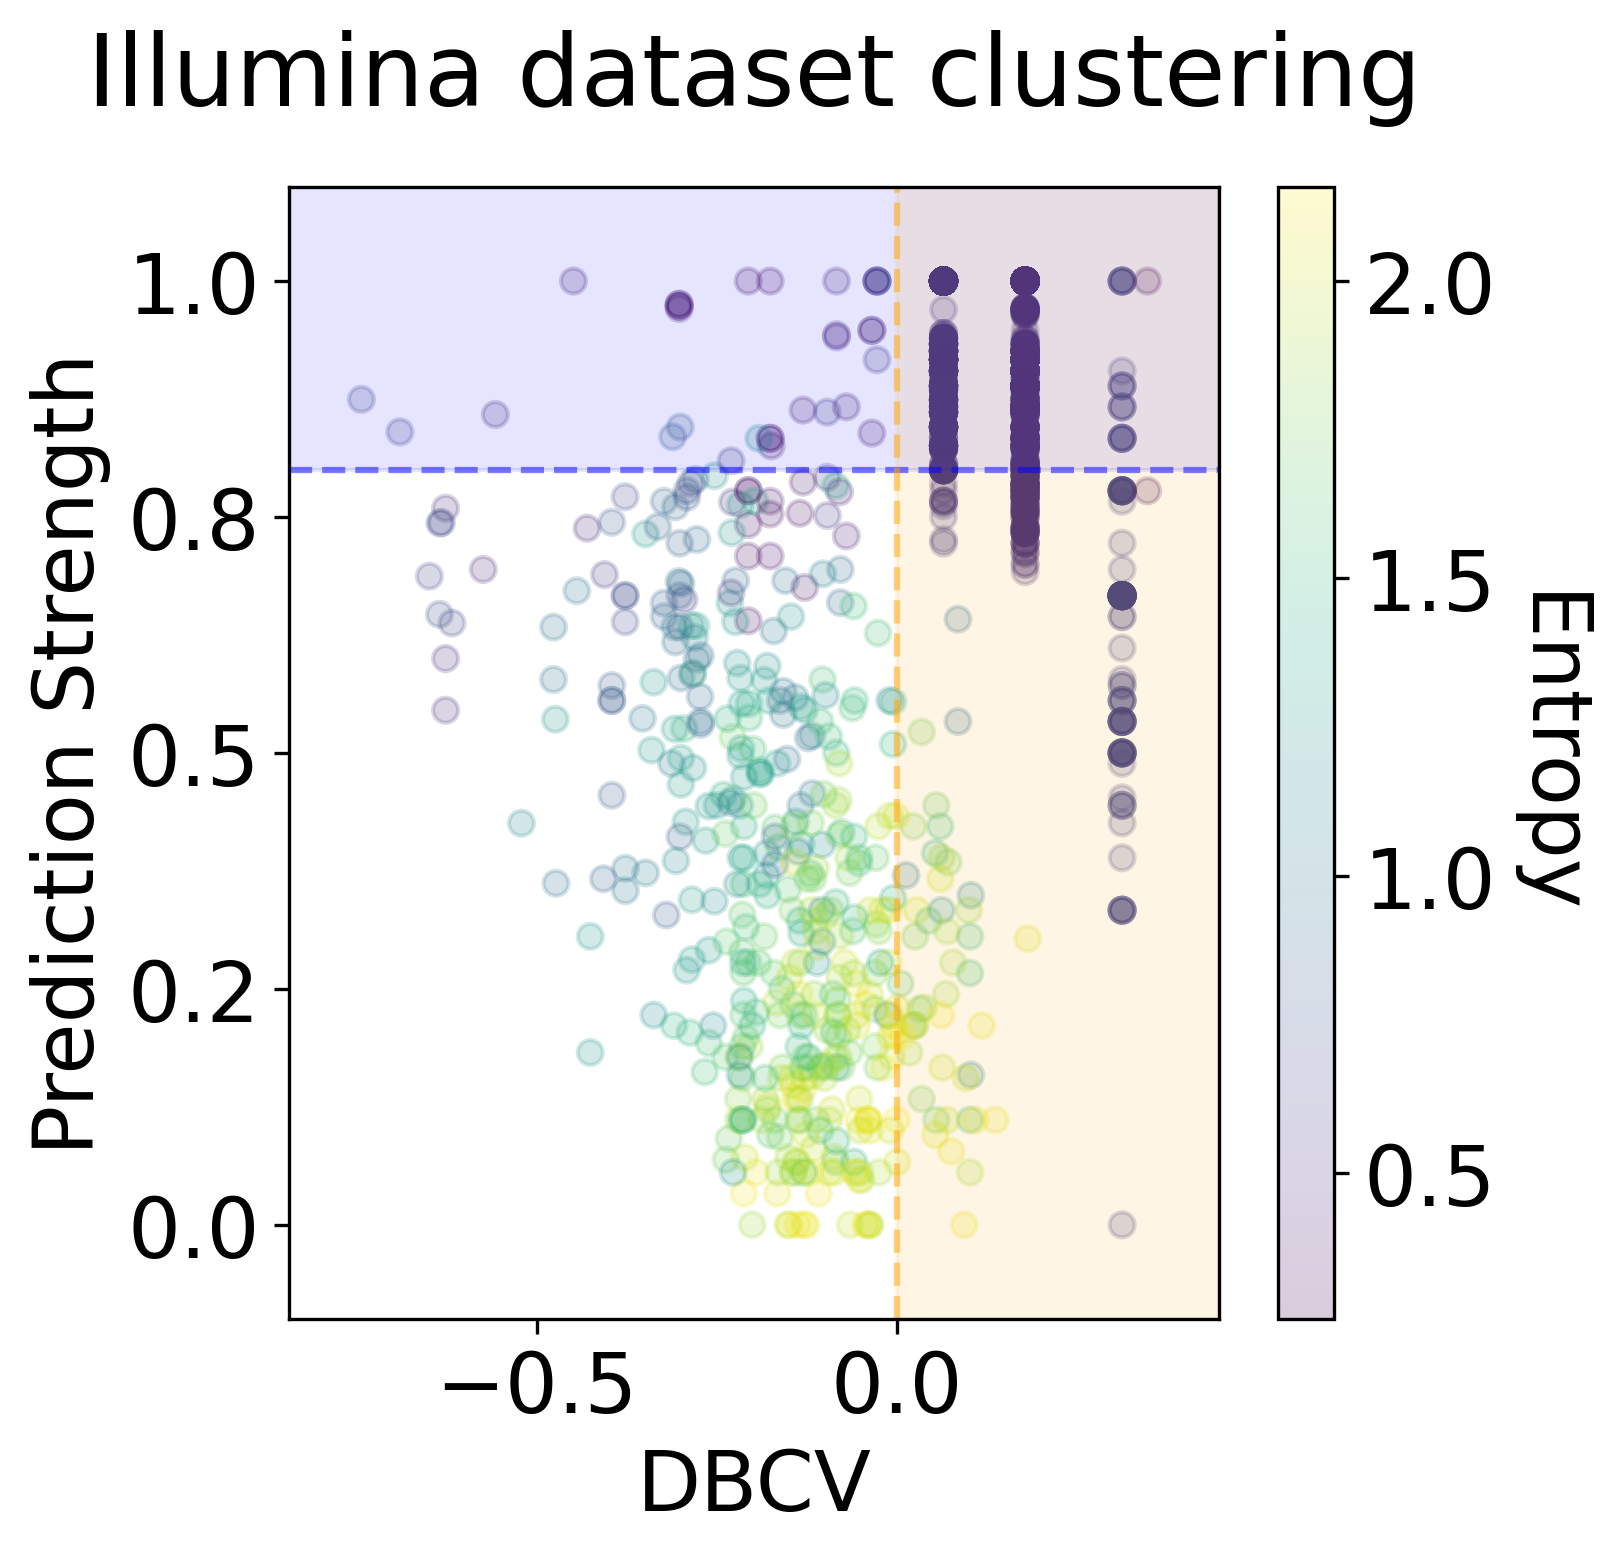

In [65]:
Illumina_df = clustering_results_df_.query('dataset == "Illumina"')

plot_clustering_scatter(Illumina_df, 
                        x_metric_name='dbcv',
                        y_metric_name='ps', 
                        coloring_metric_name='entropy', 
                        title='Illumina dataset clustering',
                        y_threshold=PS_THRESHOLD,
                        x_threshold=DBCV_THRESHOLD,
                        y_hue_line=1.2,
                        x_hue_line=1
                        )

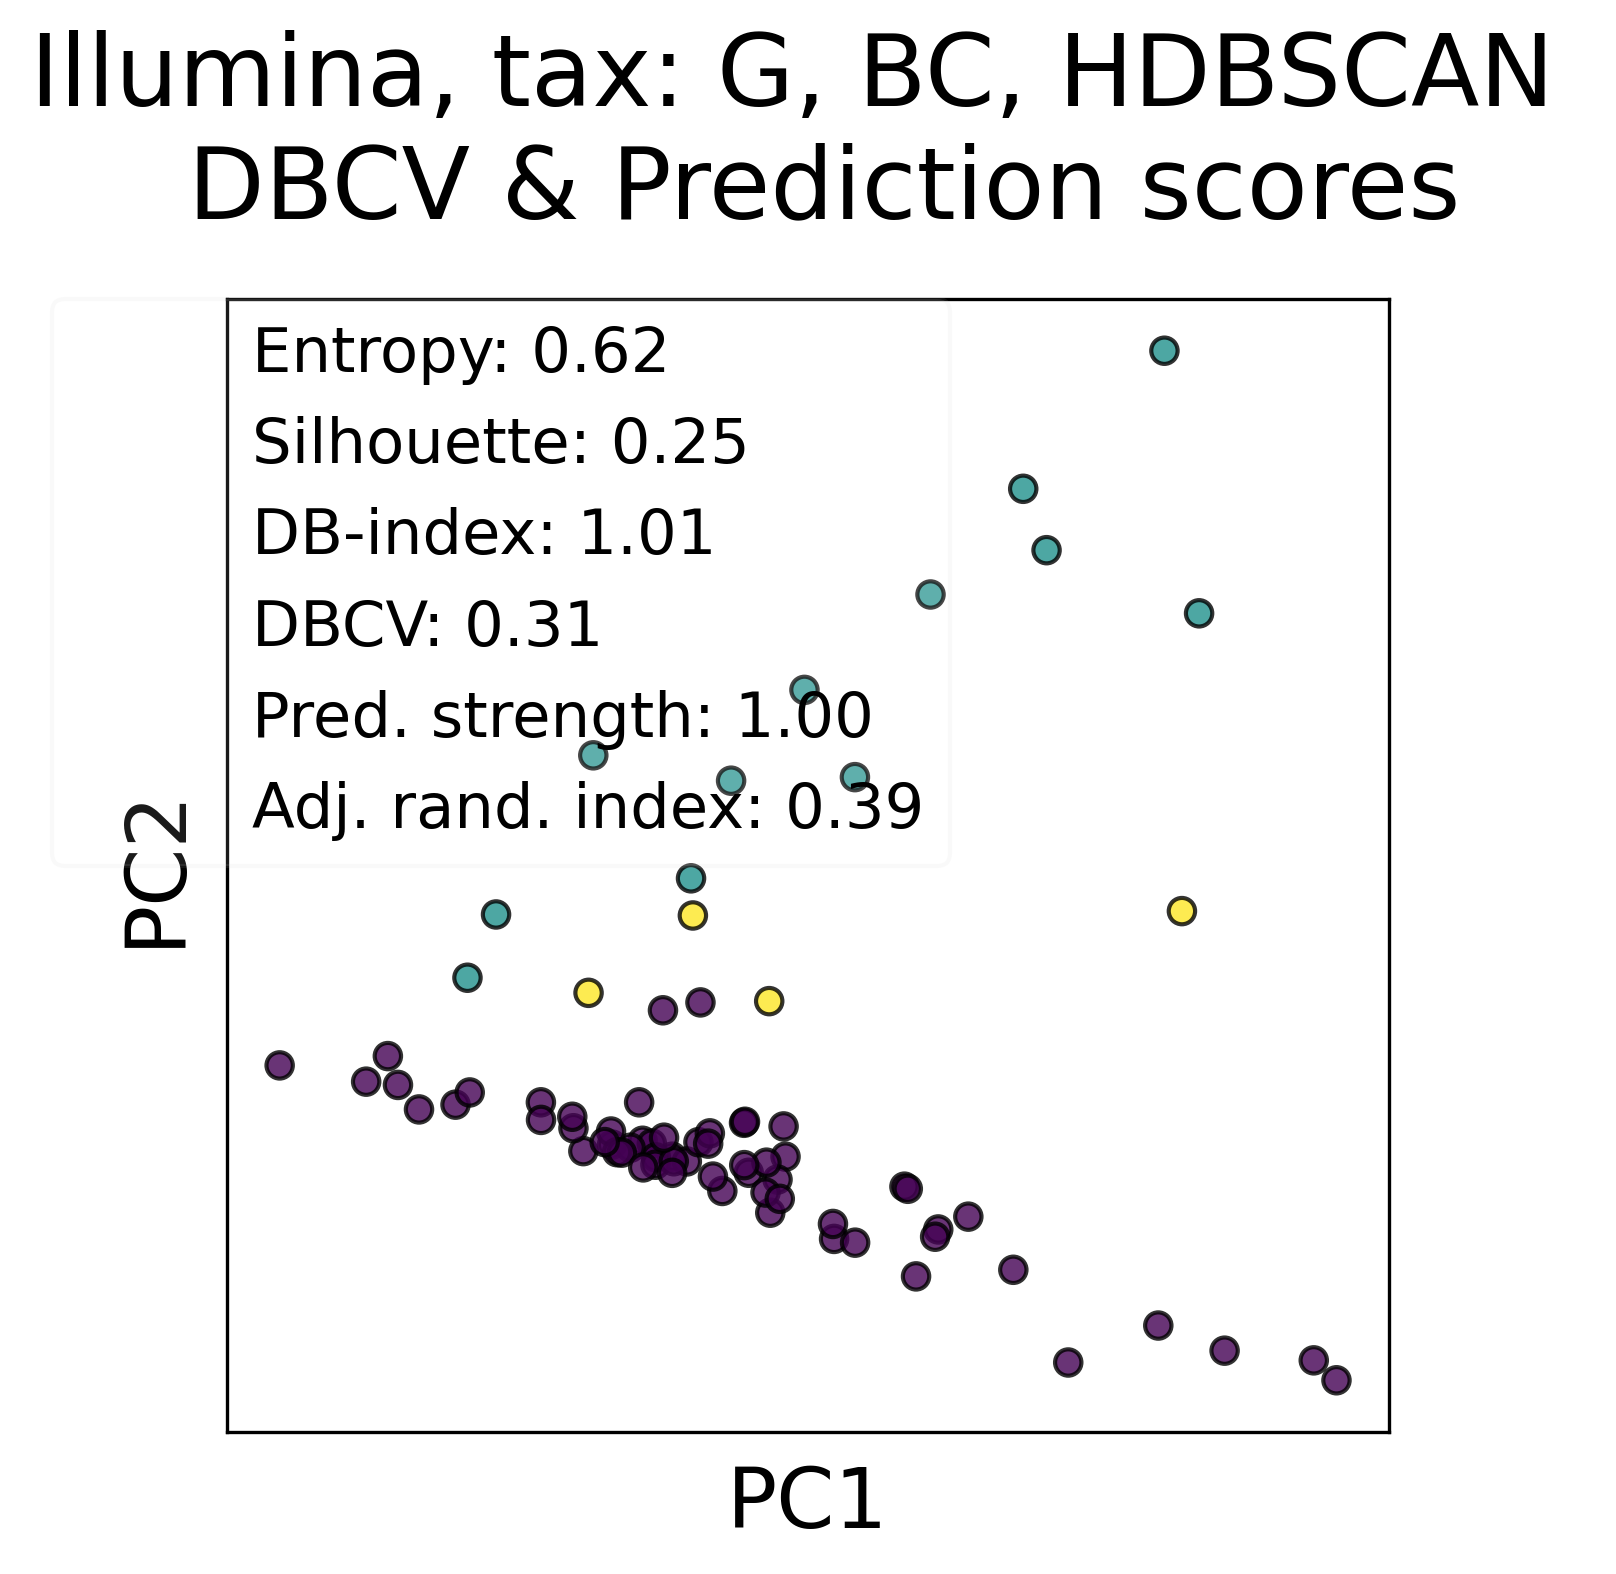

In [66]:
selection_mask_Illumina = (Illumina_df['dbcv'] > DBCV_THRESHOLD) * (Illumina_df['ps'] > PS_THRESHOLD)
df_selected = Illumina_df[selection_mask_Illumina]
idx = (df_selected['entropy']).idxmax()

best_clustering = df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']

X = data_pca['Illumina_g'][:,:2][df_mask]

ent, silh, dbind, dbcv, ps = np.array(best_clustering[['entropy', 'silh', 'dbind', 'dbcv', 'ps']].values, 
                                          dtype=np.float32).round(2)

    
RI = adjusted_rand_score(results_JS_PAM['Illumina_g']['labels'][df_mask], y)

plt.figure(figsize=(5,5), dpi=300)

plt.scatter(
            coord_to_pix(X[:,0]), 
            coord_to_pix(X[:,1]),
            c=y,
            edgecolors='black',
            s=40,
            alpha=0.8,
           )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])

handles, labels = plt.gca().get_legend_handles_labels()

text_handle = mlines.Line2D([], [], color='none', label='Entropy: {:.2f}'.format(ent))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Silhouette: {:.2f}'.format(silh))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DB-index: {:.2f}'.format(dbind))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DBCV: {:.2f}'.format(dbcv))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Pred. strength: {:.2f}'.format(ps))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Adj. rand. index: {:.2f}'.format(RI))
handles.append(text_handle)

# Add the arbitrary information patch to the legend handles
legend = plt.legend(handles=handles, 
                    loc=(-0.15,0.5), 
                    fontsize=15, 
                    frameon=True, 
                    fancybox=True, 
                    framealpha=0.1)


plt.title(f'Illumina, tax: G, {X_repr.upper()}, {X_cl_method} \n DBCV & Prediction scores')
plt.show()

## Pyroseq

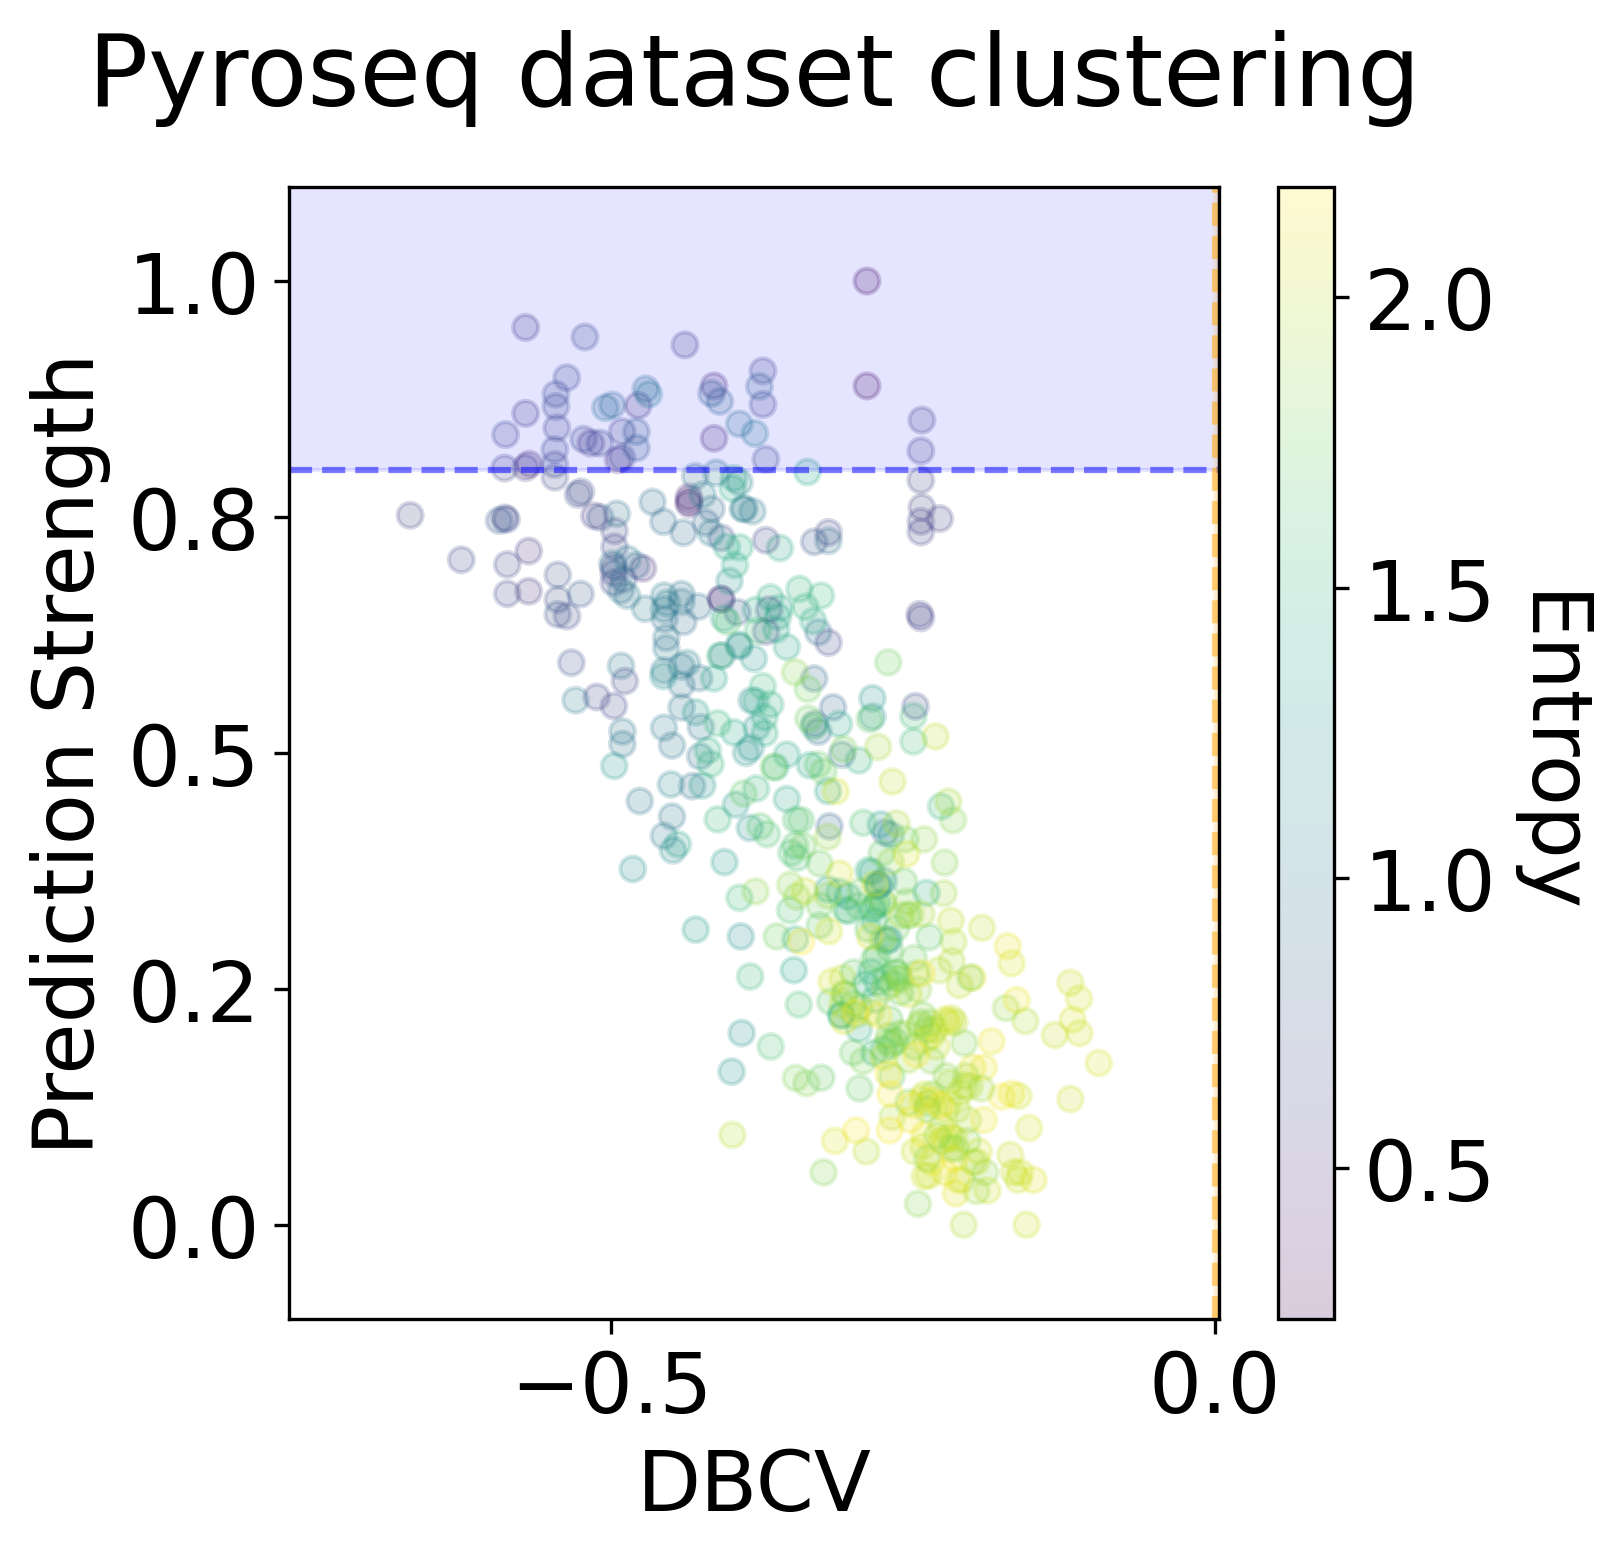

In [67]:
Pyroseq_df_ps = clustering_results_df_.query('dataset == "Pyroseq"')

plot_clustering_scatter(Pyroseq_df_ps, 
                        x_metric_name='dbcv',
                        y_metric_name='ps', 
                        coloring_metric_name='entropy', 
                        title='Pyroseq dataset clustering',
                        y_threshold=PS_THRESHOLD,
                        x_threshold=DBCV_THRESHOLD,
                        y_hue_line=1.2,
                        x_hue_line=1
                        )

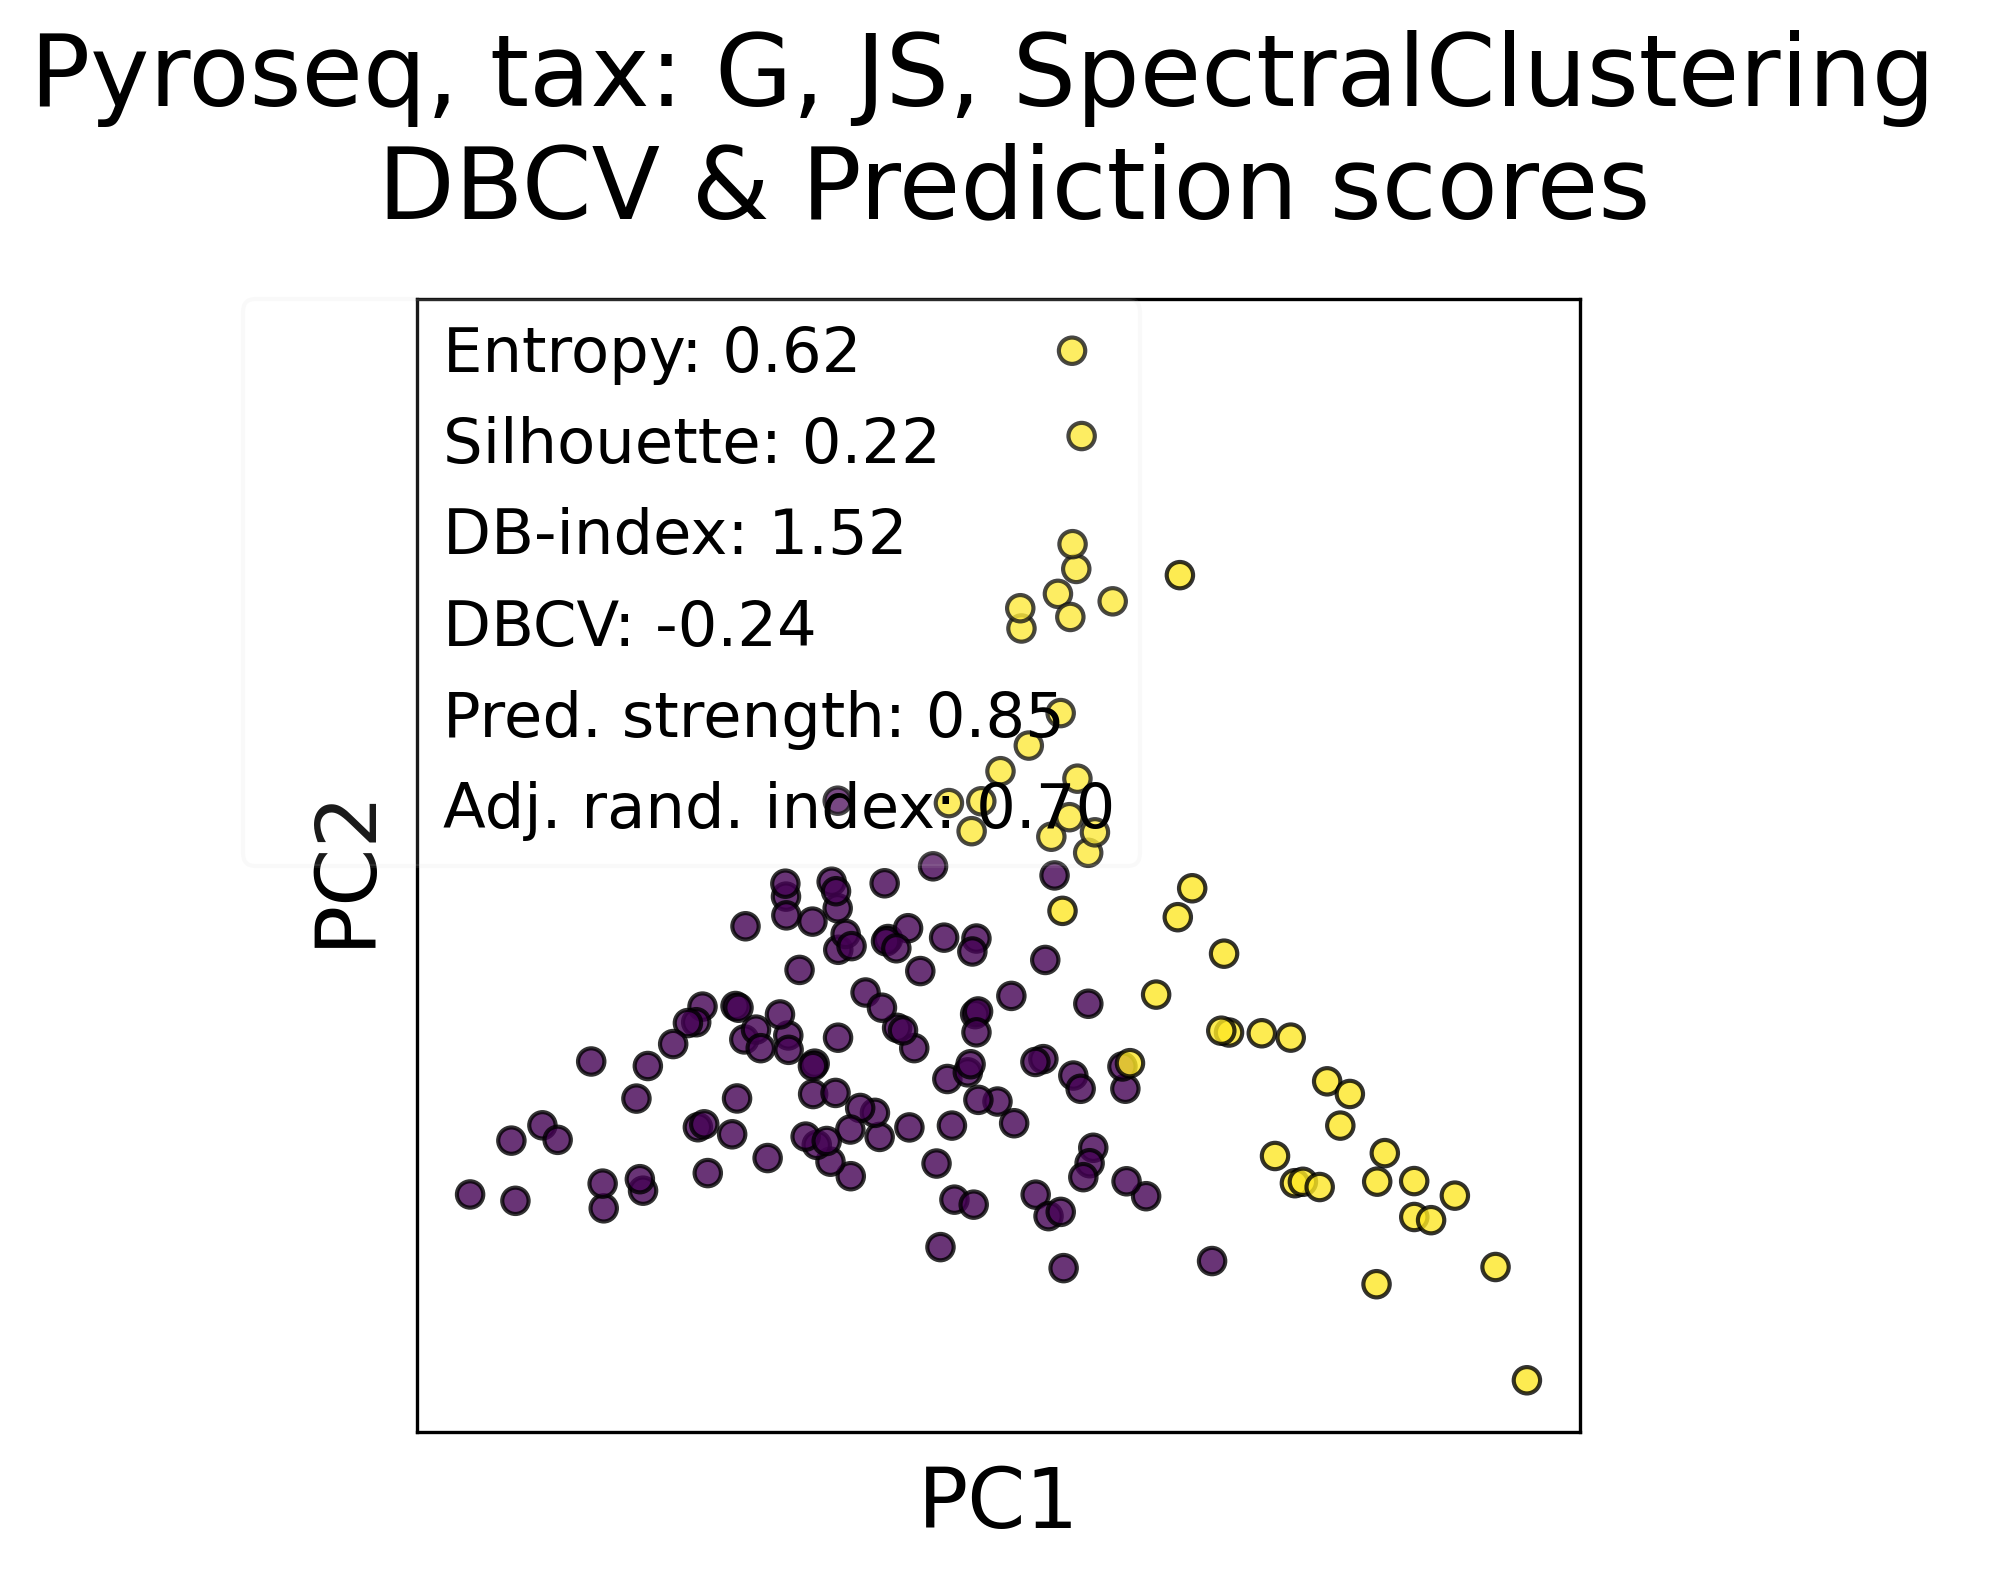

In [68]:
df_selected = Pyroseq_df_ps[(Pyroseq_df_ps['ps'] > PS_THRESHOLD) ]

idx = df_selected['dbcv'].idxmax()


best_clustering = df_selected.loc[idx]
y = best_clustering['labels']
df_mask = best_clustering['mask']
X_repr = best_clustering['representation']
X_tax = best_clustering['tax']
X_cl_method = best_clustering['cl_method']

X = data_pca['Pyroseq_g'][:,:2][df_mask]

ent, silh, dbind, dbcv, ps = np.array(best_clustering[['entropy', 'silh', 'dbind', 'dbcv', 'ps']].values, 
                                          dtype=np.float32).round(2)

RI = adjusted_rand_score(results_JS_PAM['Pyroseq_g']['labels'][df_mask], y)

plt.figure(figsize=(5,5), dpi=300)

plt.scatter(
            coord_to_pix(X[:,0]), 
            coord_to_pix(X[:,1]),
            c=y,
            edgecolors='black',
            s=40,
            alpha=0.8,
           )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([])
plt.yticks([])

handles, labels = plt.gca().get_legend_handles_labels()

text_handle = mlines.Line2D([], [], color='none', label='Entropy: {:.2f}'.format(ent))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Silhouette: {:.2f}'.format(silh))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DB-index: {:.2f}'.format(dbind))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='DBCV: {:.2f}'.format(dbcv))
handles.append(text_handle)

text_handle = mlines.Line2D([], [], color='none', label='Pred. strength: {:.2f}'.format(ps))
handles.append(text_handle)


text_handle = mlines.Line2D([], [], color='none', label='Adj. rand. index: {:.2f}'.format(RI))
handles.append(text_handle)


# Add the arbitrary information patch to the legend handles
legend = plt.legend(handles=handles, 
                    loc=(-0.15,0.5), 
                    fontsize=15, 
                    frameon=True, 
                    fancybox=True, 
                    framealpha=0.1)
plt.title(f'Pyroseq, tax: G, {X_repr.upper()}, {X_cl_method} \n DBCV & Prediction scores')
plt.show()